In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv


# ***Dummy Classifier Submission***

In [2]:
# import pandas as pd
# import numpy as np
# from sklearn.dummy import DummyClassifier

# train = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv")
# test = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv")


# X = train.drop(columns=['target'])
# y = train['target']

# dummy_class = DummyClassifier()
# dummy_class.fit(X,y)
# y_pred = dummy_class.predict(test)

# sample = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv")
# sample['target'] = y_pred

# sample.to_csv("submission.csv",index=False)

## Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Data Loading

In [4]:
train = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv")
test = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv")

# EDA & Visualization

## **Basic EDA**

### Dataset Head & Tail

In [5]:
train.head()

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
0,2009-04-17,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other,no
1,2009-10-11,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,NaN,no
2,2010-11-20,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,NaN,no
3,2009-09-01,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,NaN,no
4,2008-01-29,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,NaN,no


In [6]:
train.tail()

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
39206,2008-07-31,31,technician,single,secondary,no,0,yes,no,cellular,16,34,-1,0,NaN,no
39207,2009-07-31,59,admin.,married,primary,no,6187,no,no,cellular,114,4,-1,0,NaN,no
39208,2008-06-02,36,blue-collar,married,secondary,no,63,yes,no,NaN,56,8,-1,0,NaN,no
39209,2010-03-20,28,student,single,secondary,no,5916,no,no,cellular,93,5,-1,0,NaN,no
39210,2010-03-16,51,student,divorced,tertiary,yes,38594,yes,no,cellular,1877,19,780,148,success,yes


In [7]:
train.shape

(39211, 16)

In [8]:
test.shape

(10000, 15)

In [9]:
train.columns

Index(['last contact date', 'age', 'job', 'marital', 'education', 'default',
       'balance', 'housing', 'loan', 'contact', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome', 'target'],
      dtype='object')

In [10]:
train.isna().sum()

last contact date        0
age                      0
job                    229
marital                  0
education             1467
default                  0
balance                  0
housing                  0
loan                     0
contact              10336
duration                 0
campaign                 0
pdays                    0
previous                 0
poutcome             29451
target                   0
dtype: int64

In [11]:
round(train.isna().sum()/len(train)*100,3)

last contact date     0.000
age                   0.000
job                   0.584
marital               0.000
education             3.741
default               0.000
balance               0.000
housing               0.000
loan                  0.000
contact              26.360
duration              0.000
campaign              0.000
pdays                 0.000
previous              0.000
poutcome             75.109
target                0.000
dtype: float64

# **Insights**

* **Job** (0.584%): A small percentage of missing values in the job category might affect employment-related analysis.
* **Education** (3.741%): Some educational data is missing, which could impact the accuracy of education-level insights.
* **Contact** (26.360%): A significant portion of contact method data is missing, potentially reducing the reliability of         communication-related analysis.
* **Poutcome** (75.109%): A large percentage of missing data for previous marketing campaign outcomes could skew the 
  unerstanding of past marketing success.

In [12]:
train.describe()

,age,balance,duration,campaign,pdays,previous
count,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000
mean,42.120247,5441.781719,439.062789,5.108770,72.256051,11.826171
std,12.709352,16365.292065,769.096291,9.890153,160.942593,44.140259
min,18.000000,-8019.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,98.000000,109.000000,1.000000,-1.000000,0.000000
50%,40.000000,549.000000,197.000000,2.000000,-1.000000,0.000000
75%,50.000000,2030.000000,380.000000,4.000000,-1.000000,0.000000
max,95.000000,102127.000000,4918.000000,63.000000,871.000000,275.000000


# **Insights**

* **Age**: The average age is 42, with a range from 18 to 95, indicating a diverse age distribution.
* **Balance**: The average account balance is 5,441, but the high standard deviation (16,365) suggests significant variability,   with balances ranging from -8,019 to 102,127.
* **Duration**: The average contact duration is 439 seconds, with a wide range (0 to 4,918), indicating varied interaction       lengths.
* **Campaign**: On average, clients were contacted about 5 times, but the maximum number of contacts reached 63, showing some 
  outliers.
* **Pdays**: The average number of days since last contact was 72, but most values are -1, indicating no prior contact for the   majority.
* **Previous**: The average number of prior contacts is 11.8, with a maximum of 275, suggesting a high level of follow-up for 
  some clients.

In [13]:
categorical_cols=[]
for i in train.columns:
    print(f"{i}:{train[i].nunique()}")
    if int(train[i].nunique())<=15:
        categorical_cols.append(i)

last contact date:1013
age:78
job:11
marital:3
education:3
default:2
balance:9535
housing:2
loan:2
contact:2
duration:3146
campaign:63
pdays:865
previous:276
poutcome:3
target:2


In [14]:
categorical_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'poutcome',
 'target']

# **Insights**

Based on the condition that columns with values less than or equal to 15 are considered categorical, 9 columns fall under this category: **job**, **marital**, **education**, **default**, **housing** , **loan**, **contact**, **poutcome** and **target**.

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   last contact date  39211 non-null  object
 1   age                39211 non-null  int64 
 2   job                38982 non-null  object
 3   marital            39211 non-null  object
 4   education          37744 non-null  object
 5   default            39211 non-null  object
 6   balance            39211 non-null  int64 
 7   housing            39211 non-null  object
 8   loan               39211 non-null  object
 9   contact            28875 non-null  object
 10  duration           39211 non-null  int64 
 11  campaign           39211 non-null  int64 
 12  pdays              39211 non-null  int64 
 13  previous           39211 non-null  int64 
 14  poutcome           9760 non-null   object
 15  target             39211 non-null  object
dtypes: int64(6), object(10)
memory usage: 4.

In [16]:
train.dtypes

last contact date    object
age                   int64
job                  object
marital              object
education            object
default              object
balance               int64
housing              object
loan                 object
contact              object
duration              int64
campaign              int64
pdays                 int64
previous              int64
poutcome             object
target               object
dtype: object

In [17]:
for i in categorical_cols:
    print(train[i].value_counts()/len(train)*100)
    print()

job
blue-collar      19.831170
management       19.030374
technician       15.500752
admin.           10.497054
services          8.479763
self-employed     4.748667
retired           4.651756
entrepreneur      4.603300
unemployed        4.297264
housemaid         4.223305
student           3.552575
Name: count, dtype: float64

marital
married     57.868965
single      28.690929
divorced    13.440106
Name: count, dtype: float64

education
secondary    49.945168
tertiary     29.621790
primary      16.691745
Name: count, dtype: float64

default
no     94.243962
yes     5.756038
Name: count, dtype: float64

housing
yes    55.23195
no     44.76805
Name: count, dtype: float64

loan
no     81.150698
yes    18.849302
Name: count, dtype: float64

contact
cellular     63.834128
telephone     9.805922
Name: count, dtype: float64

poutcome
failure    12.621458
other       6.528780
success     5.740736
Name: count, dtype: float64

target
no     85.139374
yes    14.860626
Name: count, dtype: float6

# **Insights**

* **job**: The most common job categories are blue-collar (19.83%), management (19.03%), and technician (15.50%), making            up over half of the dataset. Less common roles include student (3.55%) and housemaid (4.22%).

* **marital**: The majority are married (57.87%), followed by single individuals (28.69%) and divorced (13.44%).

* **education**: Most individuals have a secondary education (49.95%), with tertiary education (29.62%) and primary                       education (16.69%) being less common.

* **default**: A significant majority (94.24%) have no history of credit default, while only 5.76% have a credit default                history.

* **housing**: More than half (55.23%) have housing loans, while 44.77% do not.

* **loan**: The majority (81.15%) do not have personal loans, with 18.85% having one.

* **contact**: Most contacts are made through cellular phones (63.83%), while 9.81% are made via telephone.

* **poutcome**: The outcome of prior marketing campaigns is mostly "failure" (12.62%), with a smaller percentage of                      "other" (6.53%) and "success" (5.74%).* 

* **target**: The majority did not subscribe to the product (85.14%), while 14.86% did.

In [18]:
train.columns

Index(['last contact date', 'age', 'job', 'marital', 'education', 'default',
       'balance', 'housing', 'loan', 'contact', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome', 'target'],
      dtype='object')

In [19]:
train['last contact date'].value_counts()

last contact date
2009-05-15    313
2008-05-15    301
2009-05-14    292
2010-05-15    292
2009-05-13    279
             ... 
2009-08-09      1
2008-08-30      1
2009-10-31      1
2009-07-26      1
2010-04-12      1
Name: count, Length: 1013, dtype: int64

# Age Column

In [20]:
train['age'].head()

0    26
1    52
2    44
3    33
4    31
Name: age, dtype: int64

In [21]:
train['age'].describe()

count    39211.000000
mean        42.120247
std         12.709352
min         18.000000
25%         33.000000
50%         40.000000
75%         50.000000
max         95.000000
Name: age, dtype: float64

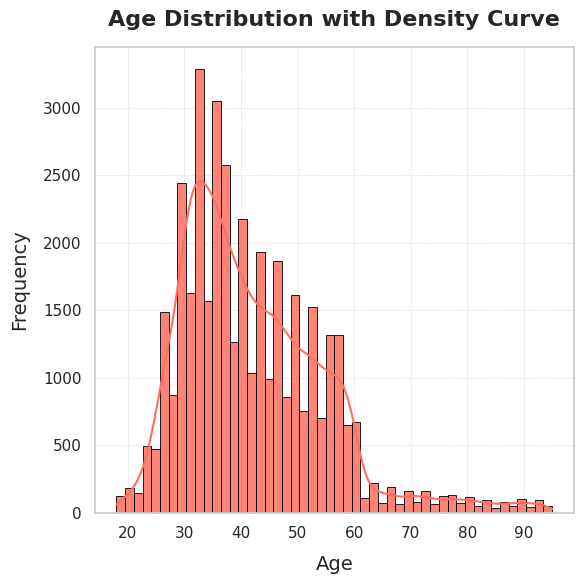

In [22]:
import warnings
# Ignore warnings
warnings.filterwarnings('ignore')

# Set a more modern and aesthetic style
sns.set(style="whitegrid", palette="pastel")

# Customize the figure size
plt.figure(figsize=(6, 6))

# Plot the histogram with enhancements
sns.histplot(x=train['age'],bins=50,color='#FF6F61',kde=True,edgecolor='black',alpha=0.85)

# Customize title and labels with a larger, bold font
plt.title("Age Distribution with Density Curve", fontsize=16, fontweight='bold', pad=15)
plt.xlabel("Age", fontsize=14, labelpad=10)
plt.ylabel("Frequency", fontsize=14, labelpad=10)

# Adding a grid with minor ticks for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Use tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


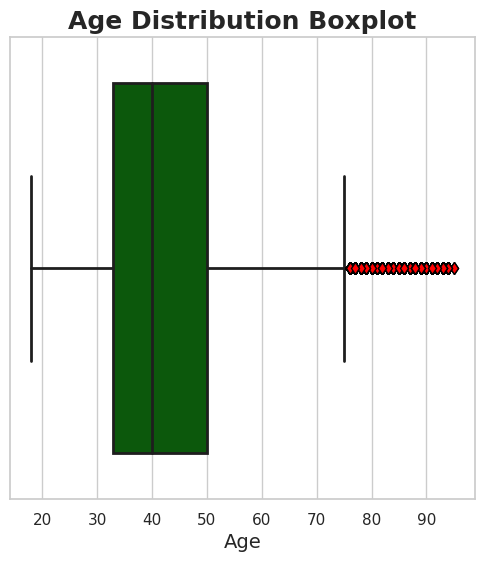

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a whitegrid style for the boxplot
sns.set(style="whitegrid")

# Customize plot size and appearance
plt.figure(figsize=(6, 6))

# Create the boxplot with custom color and edge color
sns.boxplot(x=train['age'], color='darkgreen', linewidth=2, fliersize=6, flierprops={'markerfacecolor':'red', 'markeredgecolor':'black'})

# Set plot title and labels with customized fonts
plt.title("Age Distribution Boxplot", fontsize=18, fontweight='bold')
plt.xlabel("Age", fontsize=14)

# Show the plot
plt.show()


### Insights
* **Central Tendency**: The median age (the line within the box) is around 40–50 years, indicating that half the individuals are younger than this age.

* **Spread of the Data**:The interquartile range (IQR), represented by the height of the box, suggests that the middle 50% of ages fall roughly between 30 and 50                        years.

* **Outliers**: Red dots beyond the upper whisker indicate outliers, primarily older individuals aged above ~70 years. These values are significantly higher than              the rest of the data and contribute to the positive skewness noted earlier.
* **Skewness**: The longer whisker on the right (upper side) compared to the left confirms a right-skewed distribution.

In [24]:
from scipy.stats import skew
print(skew(train['age']))

1.1242348167399974


### Insights
The skewness of the age variable in the training dataset is **1.1242**, indicating that the distribution is positively skewed.

# Job Column

In [25]:
job_counts=train['job'].value_counts()

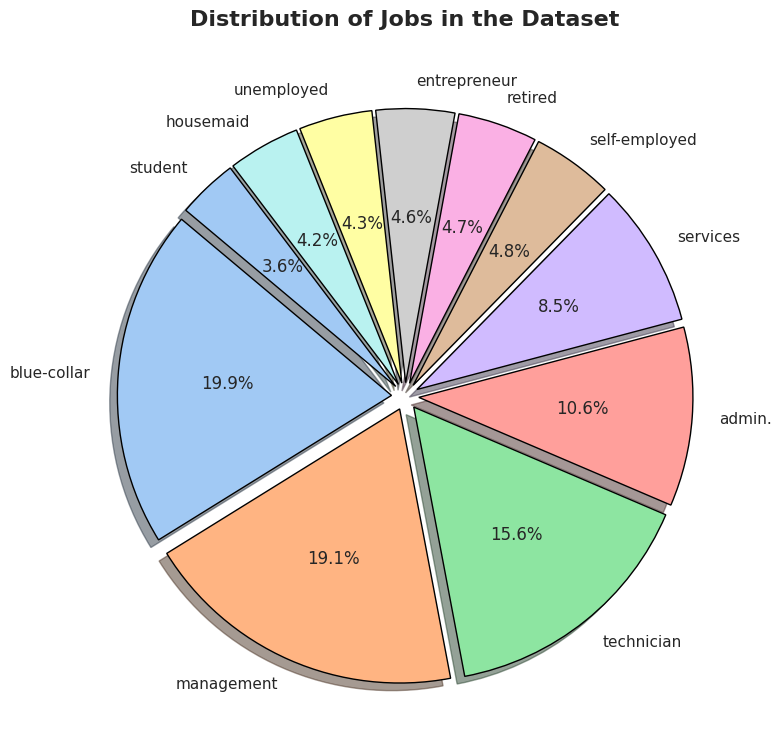

In [26]:
# Set a color palette
colors = sns.color_palette('pastel')[0:len(job_counts)]

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(job_counts,
        labels=job_counts.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=colors,
        wedgeprops={'edgecolor': 'black'},
        explode=[0.05] * len(job_counts),
        shadow=True)  

# Add a title
plt.title('Distribution of Jobs in the Dataset', fontsize=16, fontweight='bold', pad=20)

# Display the pie chart
plt.tight_layout()
plt.show()


### **Insights**
This pie chart represents the distribution of various jobs as proportions of a whole. The largest segments are for blue-collar (19.9%) and management (19.1%), indicating their prominence in the data.

# Marital Column

In [27]:
marital_counts=train['marital'].value_counts()

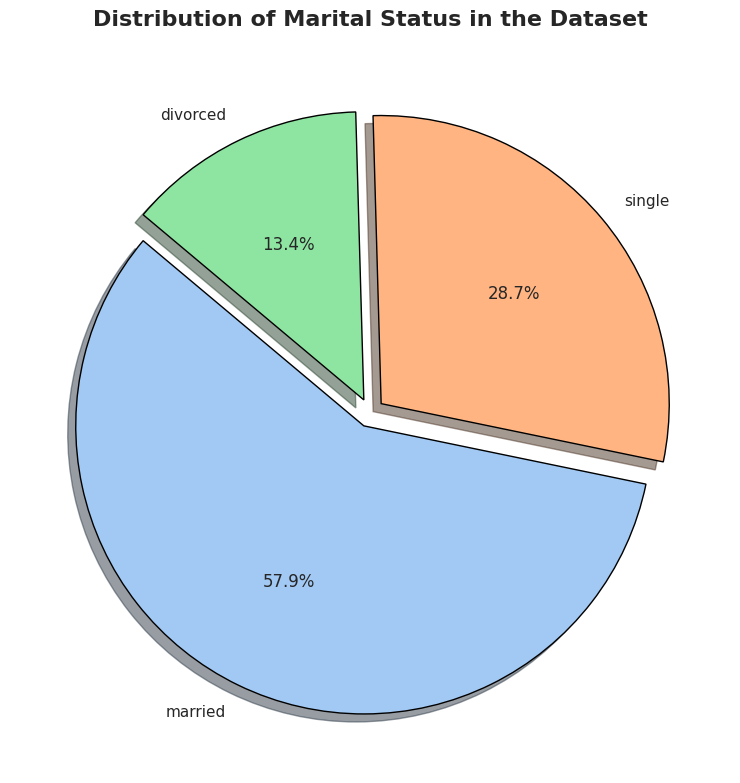

In [28]:
# Set a color palette
colors = sns.color_palette('pastel')[0:len(marital_counts)]

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(marital_counts, 
        labels=marital_counts.index, 
        autopct='%1.1f%%', 
        startangle=140,  
        colors=colors,  
        wedgeprops={'edgecolor': 'black'},  
        explode=[0.05] * len(marital_counts),  
        shadow=True) 

# Add a title
plt.title('Distribution of Marital Status in the Dataset', fontsize=16, fontweight='bold', pad=20)

# Display the pie chart
plt.tight_layout()
plt.show()


### **Insights**

This pie chart shows the distribution of marital status in the dataset. The majority are married (57.9%), followed by single (28.7%), and the smallest group is divorced (13.4%).

# Education Column

In [29]:
education_counts=train['education'].value_counts()

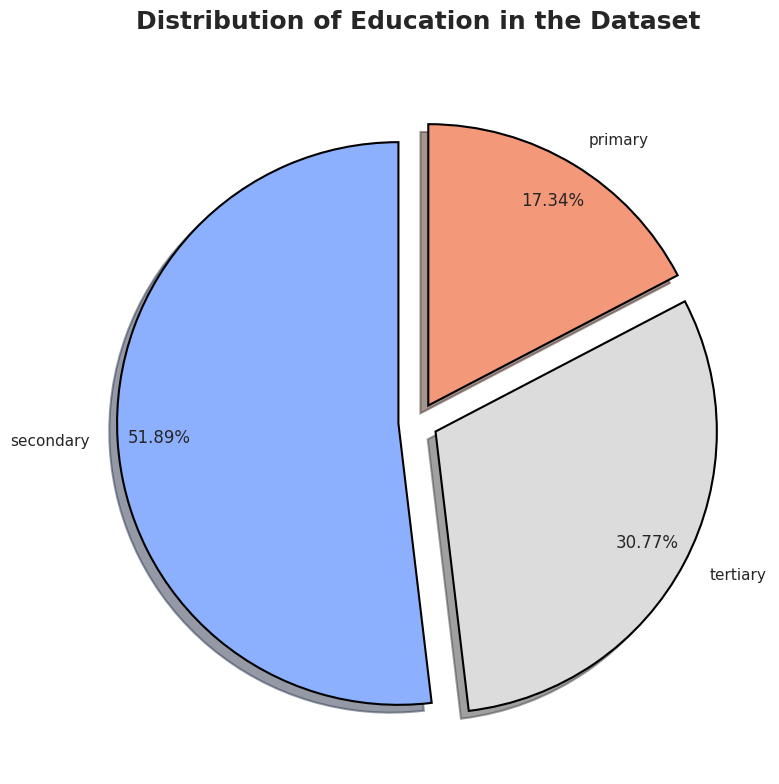

In [30]:

# Set a refined color palette (switch to a more vivid color palette for better contrast)
colors = sns.color_palette('coolwarm', n_colors=len(marital_counts))

# Create the pie chart with improvements
plt.figure(figsize=(8, 8))  
plt.pie(education_counts, 
        labels=education_counts.index, 
        autopct='%1.2f%%', 
        startangle=90,  
        colors=colors,  
        wedgeprops={'edgecolor': 'black', 'linewidth': 1.5},  
        explode=[0.07] * len(education_counts), 
        pctdistance=0.85, 
        shadow=True)

# Add a title with some additional padding
plt.title('Distribution of Education in the Dataset', fontsize=18, fontweight='bold', pad=30)

# Adjust the layout for tight fitting
plt.tight_layout()

# Display the plot
plt.show()


### **Insights**
This pie chart illustrates the distribution of education levels in the dataset. The majority have secondary education (51.89%), followed by tertiary education (30.77%), with primary education (17.34%) being the least common.

# Default Column

In [31]:
default_counts=train['default'].value_counts()

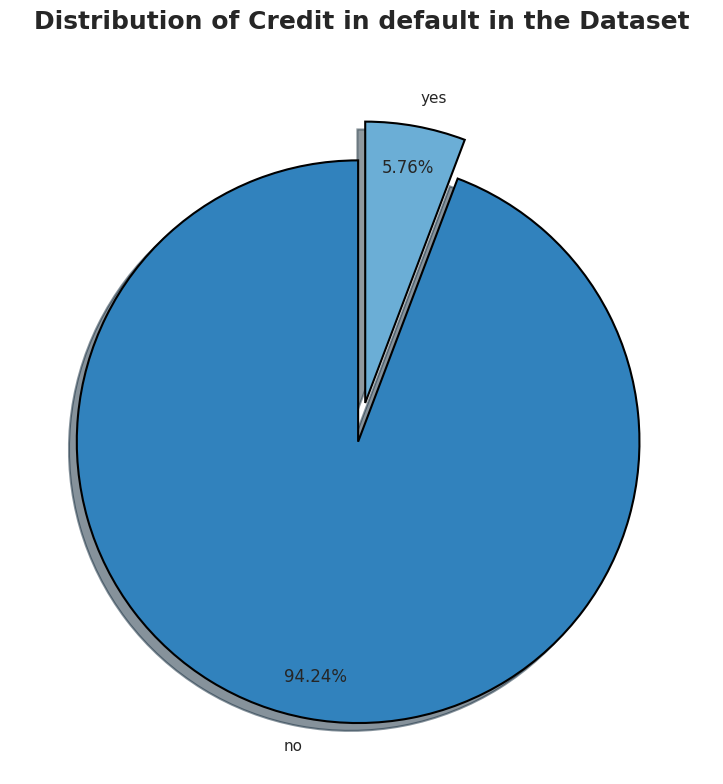

In [32]:

# Set a refined color palette (switch to a more vivid color palette for better contrast)
#colors = sns.color_palette('coolwarm', n_colors=len(marital_counts))
colors = plt.get_cmap('tab20c')(range(len(default_counts)))

# Create the pie chart with improvements
plt.figure(figsize=(8, 8))  
plt.pie(default_counts, 
        labels=default_counts.index, 
        autopct='%1.2f%%', 
        startangle=90,  
        colors=colors,  
        wedgeprops={'edgecolor': 'black', 'linewidth': 1.5},  
        explode=[0.07] * len(default_counts), 
        pctdistance=0.85, 
        shadow=True)

# Add a title with some additional padding
plt.title('Distribution of Credit in default in the Dataset', fontsize=18, fontweight='bold', pad=30)

# Adjust the layout for tight fitting
plt.tight_layout()

# Display the plot
plt.show()


### **Insights**
The pie chart illustrates the distribution of credit defaults in the dataset, showing that 94.24% of the credits are not in default ("no"), while only 5.76% are in default ("yes"). This indicates a significant class imbalance in the dataset.

# Balance Column

In [33]:
train['balance'].describe()

count     39211.000000
mean       5441.781719
std       16365.292065
min       -8019.000000
25%          98.000000
50%         549.000000
75%        2030.000000
max      102127.000000
Name: balance, dtype: float64

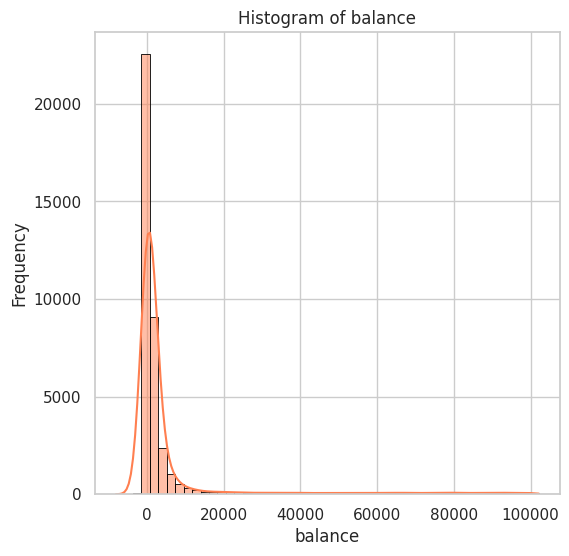

In [34]:
import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize=(6,6))

sns.histplot(x=train['balance'],bins=50,color='coral',kde=True,edgecolor='black')
plt.title("Histogram of balance")
plt.xlabel("balance")
plt.ylabel("Frequency")
plt.grid(True)

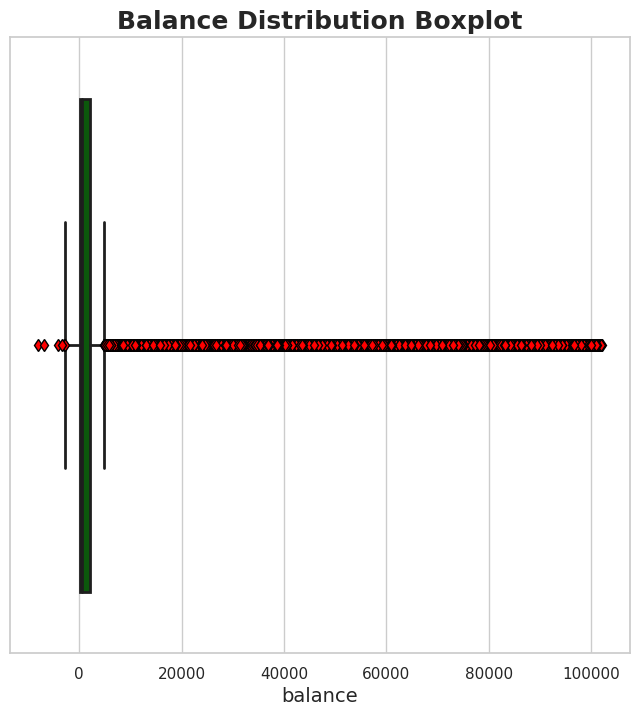

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a whitegrid style for the boxplot
sns.set(style="whitegrid")

# Customize plot size and appearance
plt.figure(figsize=(8, 8))

# Create the boxplot with custom color and edge color
sns.boxplot(x=train['balance'], color='darkgreen', linewidth=2, fliersize=6, flierprops={'markerfacecolor':'red', 'markeredgecolor':'black'})

# Set plot title and labels with customized fonts
plt.title("Balance Distribution Boxplot", fontsize=18, fontweight='bold')
plt.xlabel("balance", fontsize=14)

# Show the plot
plt.show()


### Insights
* **Distribution**:The boxplot indicates that the majority of the data is concentrated near the lower end of the balance range.
The box is very narrow, which suggests a large clustering of values near the median and a small interquartile range (IQR).

* **Outliers**:There are a significant number of outliers on the higher end (right side), extending up to 100,000. These outliers contribute to a high positive skewness, which aligns with financial data where a small number of individuals might have exceptionally high balances.
  
* **Whiskers**:The upper whisker is short compared to the range of outliers, further confirming the heavily skewed distribution.

* **Skewness**:The data is highly positively skewed, with the bulk of the observations close to 0 or within a low range, and a long tail stretching towards high values.

In [36]:
from scipy.stats import skew
print(skew(train['balance']))

4.06343156455544


### Insights
The balance variable is positively skewed (right-skewed), meaning most values are concentrated on the lower end, with a few large values on the higher end.

# Housing Column

In [37]:
housing_counts=train['housing'].value_counts()

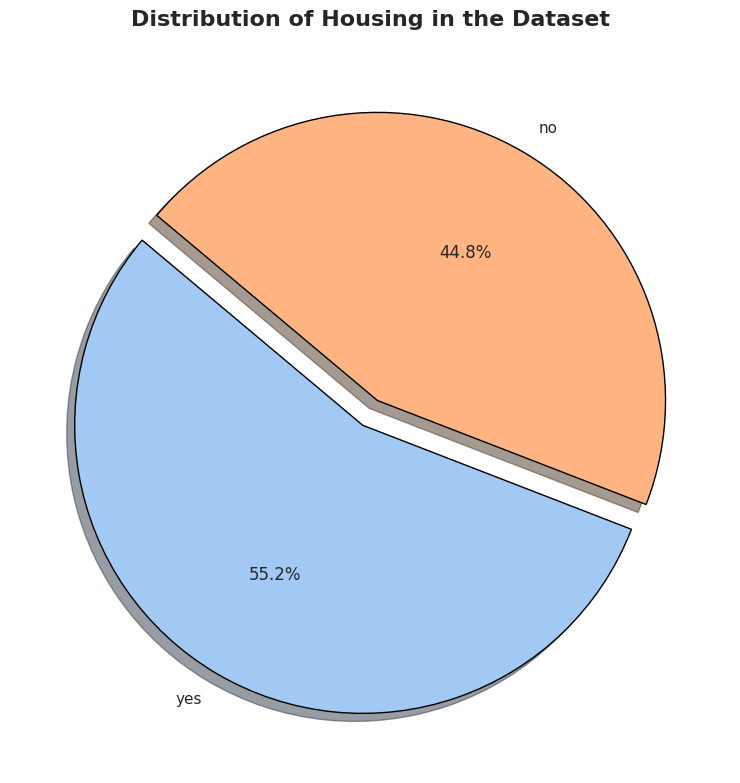

In [38]:
# Set a color palette
colors = sns.color_palette('pastel')[0:len(job_counts)]

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(housing_counts,
        labels=housing_counts.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=colors,
        wedgeprops={'edgecolor': 'black'},
        explode=[0.05] * len(housing_counts),
        shadow=True)  

# Add a title
plt.title('Distribution of Housing in the Dataset', fontsize=16, fontweight='bold', pad=20)

# Display the pie chart
plt.tight_layout()
plt.show()


### **Insights**
The pie chart shows the distribution of housing ownership in the dataset, with 55.2% of individuals owning housing ("yes") and 44.8% not owning housing ("no"). This indicates a slightly higher proportion of homeowners in the dataset.

# Loan Column

In [39]:
loan_counts=train['loan'].value_counts()

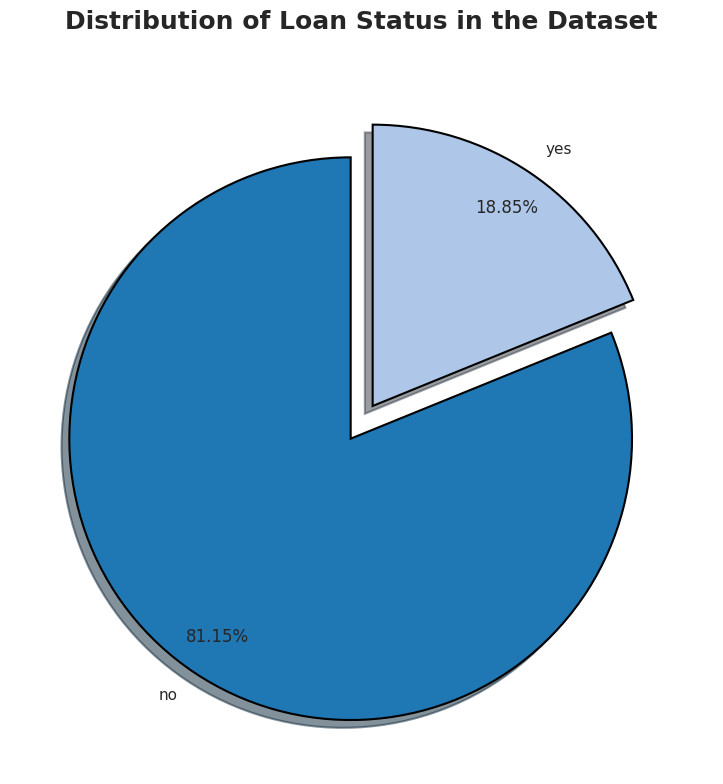

In [40]:

# Set a refined color palette (switch to a more vivid color palette for better contrast)
#colors = sns.color_palette('coolwarm', n_colors=len(marital_counts))
colors = plt.get_cmap('tab20')(range(len(loan_counts)))

# Create the pie chart with improvements
plt.figure(figsize=(8, 8))  
plt.pie(loan_counts, 
        labels=loan_counts.index, 
        autopct='%1.2f%%', 
        startangle=90,  
        colors=colors,  
        wedgeprops={'edgecolor': 'black', 'linewidth': 1.5},  
        explode=[0.07] * len(loan_counts), 
        pctdistance=0.85, 
        shadow=True)

# Add a title with some additional padding
plt.title('Distribution of Loan Status in the Dataset', fontsize=18, fontweight='bold', pad=30)

# Adjust the layout for tight fitting
plt.tight_layout()

# Display the plot
plt.show()


### **Insights**
The pie chart illustrates the distribution of loan status in the dataset, with 81.15% of individuals not having a loan ("no") and 18.85% having a loan ("yes"). This indicates a majority of the population does not hold loans.

# Contact Column

In [41]:
contact_counts=train['contact'].value_counts()

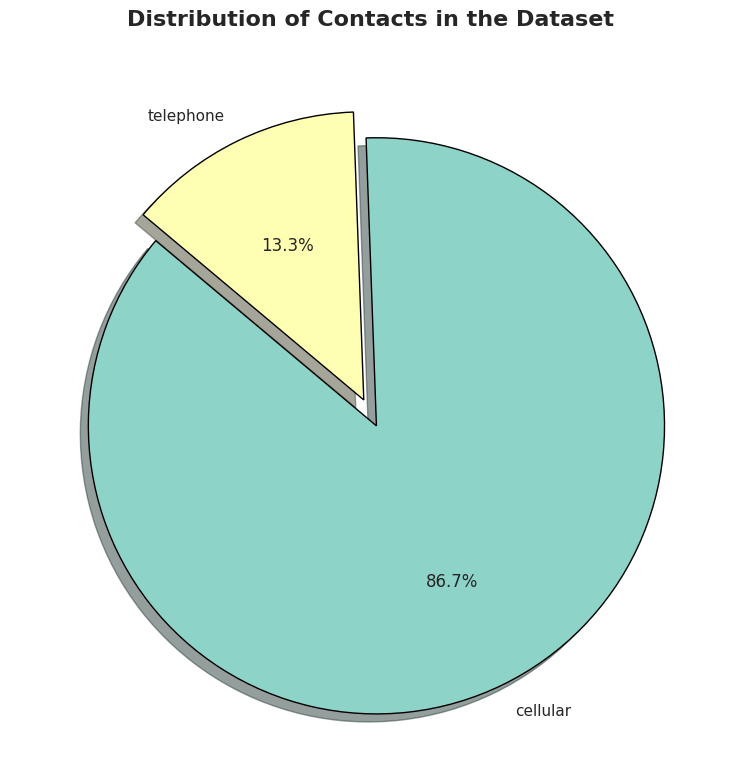

In [42]:
# Set a color palette
colors = sns.color_palette('Set3')[0:len(contact_counts)]

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(contact_counts,
        labels=contact_counts.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=colors,
        wedgeprops={'edgecolor': 'black'},
        explode=[0.05] * len(contact_counts),
        shadow=True)  

# Add a title
plt.title('Distribution of Contacts in the Dataset', fontsize=16, fontweight='bold', pad=20)

# Display the pie chart
plt.tight_layout()
plt.show()


### **Insights**
The pie chart illustrates the distribution of contacts communication type in the dataset, with 86.7% of individuals using cellular for communication and 13.3% using telephone for communication.

# Poutcome Column 

In [43]:
poutcome_counts=train['poutcome'].value_counts()

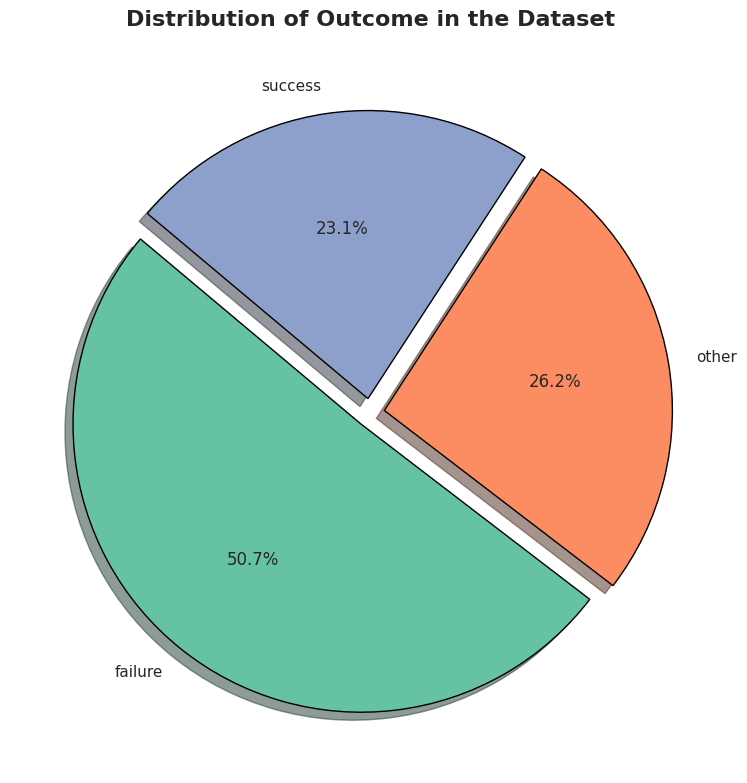

In [44]:
# Set a color palette
colors = sns.color_palette('Set2')[0:len(poutcome_counts)]

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(poutcome_counts,
        labels=poutcome_counts.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=colors,
        wedgeprops={'edgecolor': 'black'},
        explode=[0.05] * len(poutcome_counts),
        shadow=True)  

# Add a title
plt.title('Distribution of Outcome in the Dataset', fontsize=16, fontweight='bold', pad=20)

# Display the pie chart
plt.tight_layout()
plt.show()


### **Insights**
The pie chart illustrates the distribution of outcome of the previous marketing campaign in the dataset, with 50.7%  outcome as 'failure' , 26.2% outcome as 'other' and 23.1% outcome as 'success'.

In [45]:
from scipy.stats import chi2_contingency

# Create a contingency table for the categorical variables
contingency_table = pd.crosstab(train['poutcome'], train['target'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Check p-value to determine significance
print(f"Chi2 Statistic: {chi2}, p-value: {p}")



Chi2 Statistic: 1073.3281715114106, p-value: 8.506461106341178e-234


* Since the p-value is significantly below 0.05, you can reject the null hypothesis that there is no association between the categorical feature and the target variable.
* This result suggests that there is a statistically significant association between the categorical feature and the target variable.

In [46]:
def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

# Example usage
cramers_v_score = cramers_v(train['poutcome'], train['target'])
print(f"Cramer’s V: {cramers_v_score}")


Cramer’s V: 0.33162048899371616


A higher Cramer’s V score (closer to 1) indicates a stronger association between the feature and the target.
The score of 0.33 implies that there is some relationship between the categorical feature and the target, but it's not particularly strong. 

# Target Column

In [47]:
target_counts=train['target'].value_counts()

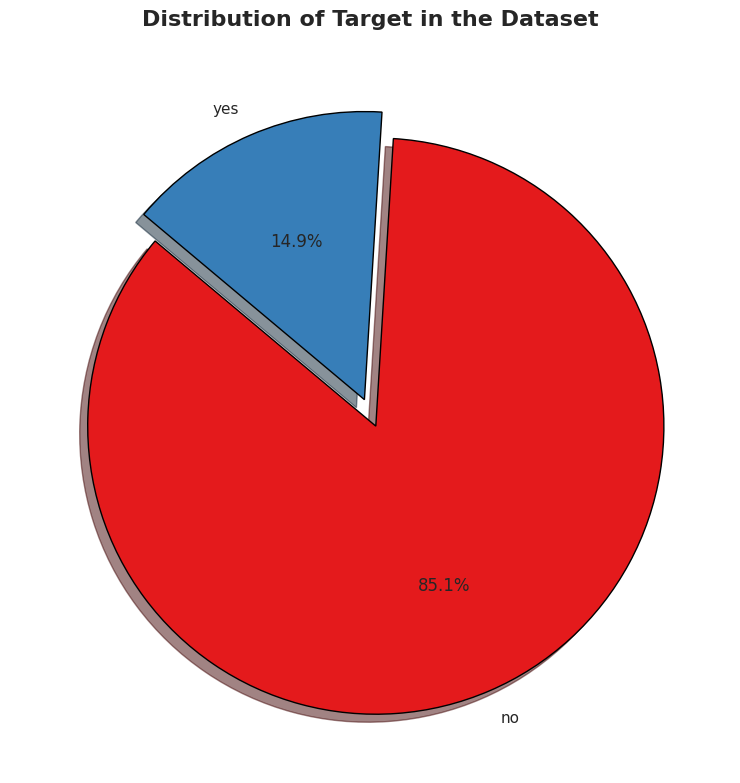

In [48]:
# Set a color palette
colors = sns.color_palette('Set1')[0:len(target_counts)]

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(target_counts,
        labels=target_counts.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=colors,
        wedgeprops={'edgecolor': 'black'},
        explode=[0.05] * len(target_counts),
        shadow=True)  

# Add a title
plt.title('Distribution of Target in the Dataset', fontsize=16, fontweight='bold', pad=20)

# Display the pie chart
plt.tight_layout()
plt.show()


# Last Contact Date Column

In [49]:
train['last contact date'] = pd.to_datetime(train['last contact date'])
train['year'] = train['last contact date'].dt.year
train['month'] = train['last contact date'].dt.month
train['weekday'] = train['last contact date'].dt.weekday

In [50]:
test['last contact date'] = pd.to_datetime(test['last contact date'])
test['year'] = test['last contact date'].dt.year
test['month'] = test['last contact date'].dt.month
test['weekday'] = test['last contact date'].dt.weekday

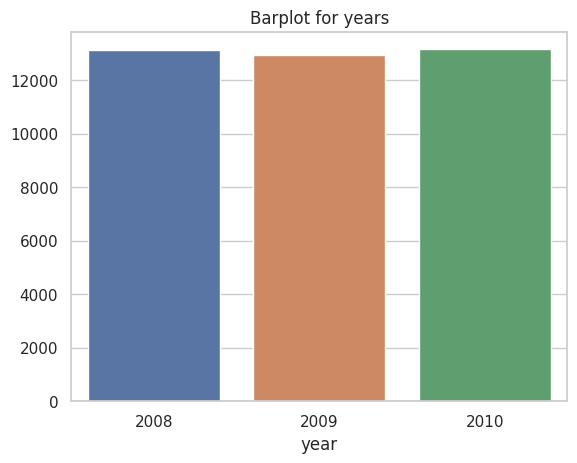

In [51]:
year_value_counts = train['year'].value_counts().sort_index()

sns.barplot(x=year_value_counts.index,y=year_value_counts.values)
plt.title("Barplot for years")
plt.show()

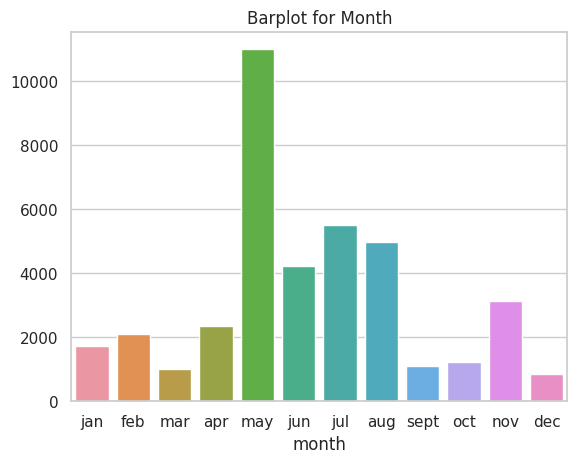

In [52]:
month_value_counts = train['month'].value_counts().sort_index()

sns.barplot(x=month_value_counts.index, y=month_value_counts.values)

plt.xticks(ticks=range(len(month_value_counts.index)), labels=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sept', 'oct', 'nov', 'dec'])

plt.title("Barplot for Month")
plt.show()


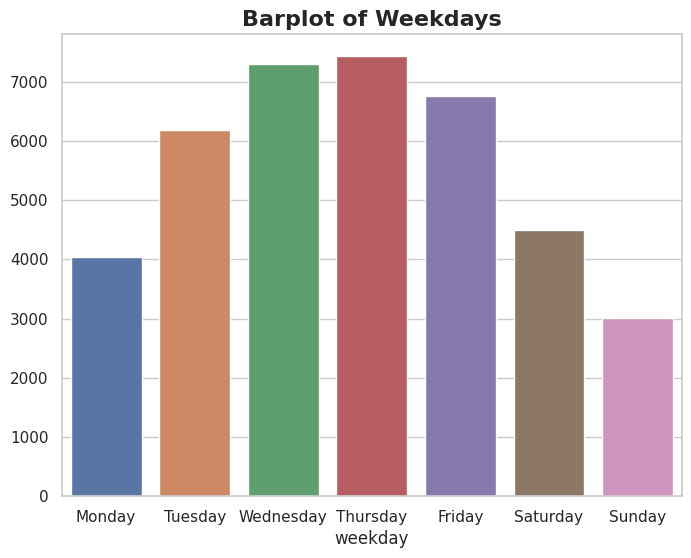

In [53]:
# Get the count of weekdays and sort by index
weekday_value_counts = train['weekday'].value_counts().sort_index()

# Map numerical values to day names (assuming 0 = Monday, 6 = Sunday)
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create the bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=weekday_value_counts.index, y=weekday_value_counts.values)

# Set custom tick labels to the day names
plt.xticks(ticks=weekday_value_counts.index, labels=day_names)

# Add a title
plt.title("Barplot of Weekdays", fontsize=16, fontweight='bold')

# Display the plot
plt.show()

In [54]:
train['age'].unique()

array([26, 52, 44, 33, 31, 25, 46, 37, 38, 32, 28, 34, 86, 42, 58, 39, 35,
       47, 45, 48, 30, 50, 56, 54, 40, 53, 41, 51, 27, 29, 57, 63, 36, 43,
       19, 55, 49, 23, 83, 60, 22, 80, 76, 59, 24, 93, 71, 89, 64, 68, 85,
       79, 62, 69, 20, 90, 66, 87, 72, 88, 67, 70, 77, 91, 78, 61, 65, 73,
       74, 84, 82, 92, 81, 18, 21, 75, 94, 95])

In [55]:
age_cat = []
for i in train['age']:
    if int(i)<30:
        age_cat.append("young")
    elif i<=50:
        age_cat.append("middle")
    else:
        age_cat.append("old")

In [56]:
train['age_cat'] = age_cat

In [57]:
train['age_cat'].value_counts()

age_cat
middle    25315
old        9142
young      4754
Name: count, dtype: int64

In [58]:
train.columns

Index(['last contact date', 'age', 'job', 'marital', 'education', 'default',
       'balance', 'housing', 'loan', 'contact', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome', 'target', 'year', 'month', 'weekday',
       'age_cat'],
      dtype='object')

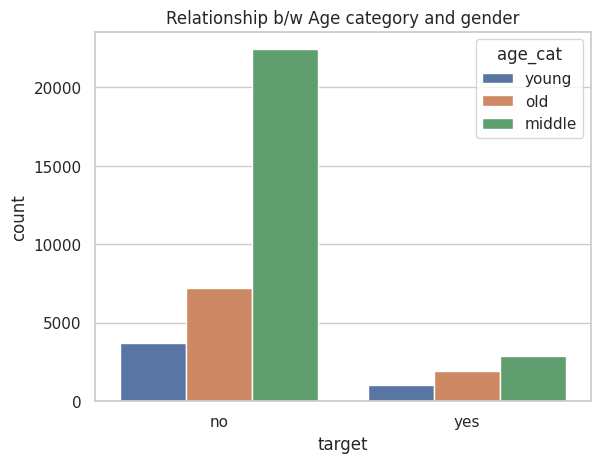

In [59]:
sns.countplot(x='target',hue='age_cat',data=train)
plt.title("Relationship b/w Age category and gender")
plt.show()

# **Preprocessing**

In [60]:
train = train.drop(columns = ['last contact date','age_cat'])
test = test.drop(columns = ['last contact date'])

* **Splitting features and target variables**

In [61]:
X = train.drop(columns = ['target'])
y = train['target']

In [62]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

In [63]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        39211 non-null  int64 
 1   job        38982 non-null  object
 2   marital    39211 non-null  object
 3   education  37744 non-null  object
 4   default    39211 non-null  object
 5   balance    39211 non-null  int64 
 6   housing    39211 non-null  object
 7   loan       39211 non-null  object
 8   contact    28875 non-null  object
 9   duration   39211 non-null  int64 
 10  campaign   39211 non-null  int64 
 11  pdays      39211 non-null  int64 
 12  previous   39211 non-null  int64 
 13  poutcome   9760 non-null   object
 14  target     39211 non-null  object
 15  year       39211 non-null  int32 
 16  month      39211 non-null  int32 
 17  weekday    39211 non-null  int32 
dtypes: int32(3), int64(6), object(9)
memory usage: 4.9+ MB


# Approach-1

In [64]:
# num = X.select_dtypes(include = ['int32','int64','float64']).columns
# cat = X.select_dtypes(include = ['object']).columns

In [65]:
# num_pipe = Pipeline([
#     ('imputer', SimpleImputer(strategy = 'mean')),
#     ('scaler', StandardScaler())
# ])
# num_pipe

In [66]:
# cat_pipe = Pipeline([
#     ('imputer', SimpleImputer(strategy = 'most_frequent')),
#     ('encoder', OneHotEncoder(handle_unknown = 'ignore'))
# ])
# cat_pipe

In [67]:
# preprocessor = ColumnTransformer(
# transformers = [
#     ('numerical', num_pipe, num),
#     ('categorical', cat_pipe, cat)
# ])
# preprocessor

In [68]:
# X_train_transformed = preprocessor.fit_transform(X_train)
# X_val_transformed = preprocessor.fit_transform(X_val)

# Converting arrays to DataFrame

In [69]:
# X_train_transformed = pd.DataFrame(X_train_transformed)
# X_val_transformed = pd.DataFrame(X_val_transformed)

# Approach-2

# Converting Categorical Columns to Numerical Columns

In [70]:
cate_col = list(X_train.select_dtypes(include=['object']).columns)
cate_col

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'poutcome']

In [71]:
X_train = pd.DataFrame(X_train)
X_val = pd.DataFrame(X_val)
test = pd.DataFrame(test)

In [72]:
col=X_train.columns
col

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous',
       'poutcome', 'year', 'month', 'weekday'],
      dtype='object')

In [73]:
encoder_dict = {}
for i in cate_col:
    enc = LabelEncoder()
    X_train[i] = enc.fit_transform(X_train[i])
    X_val[i] = enc.transform(X_val[i])
    test[i] = enc.transform(test[i])
    encoder_dict[i] = enc

# Imputation

In [74]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(random_state=0)
X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)
test = imputer.transform(test)

X_train = pd.DataFrame(X_train,columns=col)
X_val = pd.DataFrame(X_val,columns=col)
test = pd.DataFrame(test,columns=col)

### Label-Column Encoding

In [75]:
label = LabelEncoder()
y_train = label.fit_transform(y_train)
y_val = label.transform(y_val)

## Feature Selection(to get good features)

### Select K Best

In [76]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
selector = SelectKBest(mutual_info_classif,k=10)
X_selected_train = selector.fit_transform(X_train,y_train)
X_selected_val = selector.transform(X_val)
test_selected = selector.transform(test)
X_selected_train = pd.DataFrame(X_selected_train,columns=X_train.columns[selector.get_support()])
X_selected_val = pd.DataFrame(X_selected_val,columns=X_train.columns[selector.get_support()])
test_selected = pd.DataFrame(test_selected,columns=X_train.columns[selector.get_support()])

In [77]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
selector = SelectKBest(f_classif,k=10)
X_selected_train = selector.fit_transform(X_train,y_train)
X_selected_val = selector.transform(X_val)
test_selected = selector.transform(test)
X_selected_train = pd.DataFrame(X_selected_train,columns=X_train.columns[selector.get_support()])
X_selected_val = pd.DataFrame(X_selected_val,columns=X_train.columns[selector.get_support()])
test_selected = pd.DataFrame(test_selected,columns=X_train.columns[selector.get_support()])

In [78]:
X_selected_train

,age,default,balance,housing,contact,duration,campaign,pdays,previous,poutcome
0,49.0,0.0,1253.0,1.0,0.0,83.0,2.0,-1.0,0.0,3.0
1,61.0,0.0,1389.0,0.0,0.0,250.0,1.0,-1.0,0.0,3.0
2,56.0,0.0,94.0,0.0,0.0,530.0,3.0,-1.0,0.0,3.0
3,47.0,0.0,505.0,0.0,2.0,152.0,3.0,-1.0,0.0,3.0
4,32.0,0.0,930.0,1.0,2.0,122.0,1.0,-1.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...
31363,39.0,0.0,316.0,0.0,0.0,100.0,1.0,-1.0,0.0,3.0
31364,46.0,0.0,145.0,1.0,0.0,113.0,2.0,270.0,5.0,0.0
31365,44.0,0.0,1310.0,1.0,2.0,290.0,1.0,-1.0,0.0,3.0
31366,37.0,0.0,588.0,1.0,0.0,65.0,4.0,-1.0,0.0,3.0


### **Insights**
Selects top 10 features based on mutual information between features and the target and those features are as follows:
* marital
* education
* default
* housing
* loan
* contact
* campaign
* poutcome
* weekday

### RFE (Recursive Feature Elimination)

In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
model = LogisticRegression()
rfe_selector = RFE(model,n_features_to_select=10)
X_selected_train = rfe_selector.fit_transform(X_train,y_train)
X_selected_val = rfe_selector.transform(X_val)
test_selected = rfe_selector.transform(test)
X_selected_train = pd.DataFrame(X_selected_train,columns=X_train.columns[rfe_selector.get_support()])
X_selected_val = pd.DataFrame(X_selected_val,columns=X_train.columns[rfe_selector.get_support()])
test_selected = pd.DataFrame(test_selected,columns=X_train.columns[rfe_selector.get_support()])

In [80]:
X_selected_train

,job,marital,education,default,housing,loan,contact,campaign,poutcome,weekday
0,4.0,0.0,2.0,0.0,1.0,0.0,0.0,2.0,3.0,3.0
1,3.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0
2,4.0,1.0,2.0,0.0,0.0,0.0,0.0,3.0,3.0,2.0
3,7.0,1.0,1.0,0.0,0.0,0.0,2.0,3.0,3.0,4.0
4,9.0,2.0,1.0,0.0,1.0,0.0,2.0,1.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...
31363,9.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,4.0
31364,4.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,6.0
31365,6.0,1.0,1.0,0.0,1.0,0.0,2.0,1.0,3.0,4.0
31366,9.0,1.0,1.0,0.0,1.0,0.0,0.0,4.0,3.0,4.0


### **Insights**
Iteratively removes features to identify the most important ones. Those features are as follows:
* job
* marital
* education
* default
* housing
* loan
* contact
* campaign
* poutcome
* weekday

In [81]:
cat_cols=['job','marital','education','default','housing','loan','contact','poutcome','weekday']
num_cols=['age','balance','duration','campaign','pdays','previous']

In [82]:
Transformer = ColumnTransformer([('scale',StandardScaler(),num_cols),
                                ('onehot',OneHotEncoder(),cat_cols)],remainder='passthrough')

In [83]:
X_train_transformed = pd.DataFrame(Transformer.fit_transform(X_train),columns=Transformer.get_feature_names_out())
X_val_transformed = pd.DataFrame(Transformer.transform(X_val),columns = Transformer.get_feature_names_out())
test_transformed = pd.DataFrame(Transformer.transform(test),columns = Transformer.get_feature_names_out())

In [84]:
X_train_transformed.head()

,scale__age,scale__balance,scale__duration,scale__campaign,scale__pdays,scale__previous,onehot__job_0.0,onehot__job_1.0,onehot__job_2.0,onehot__job_3.0,...,onehot__poutcome_3.0,onehot__weekday_0.0,onehot__weekday_1.0,onehot__weekday_2.0,onehot__weekday_3.0,onehot__weekday_4.0,onehot__weekday_5.0,onehot__weekday_6.0,remainder__year,remainder__month
0,0.534135,-0.256373,-0.463392,-0.315658,-0.455879,-0.268796,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2009.0,5.0
1,1.472544,-0.248094,-0.245215,-0.416674,-0.455879,-0.268796,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2010.0,4.0
2,1.081540,-0.326926,0.120589,-0.214642,-0.455879,-0.268796,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2008.0,7.0
3,0.377734,-0.301907,-0.373247,-0.214642,-0.455879,-0.268796,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2008.0,6.0
4,-0.795278,-0.276036,-0.412440,-0.416674,-0.455879,-0.268796,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2009.0,5.0


# **Feature Engineering** (after preprocessing) 

## **PCA**

In [85]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 30)
X_train_reduced_pca = pca.fit_transform(X_train_transformed)
X_val_reduced_pca = pca.transform(X_val_transformed)
test_reduced_pca = pca.transform(test_transformed)

In [86]:
X_train_pca = pd.DataFrame(X_train_reduced_pca)
X_val_pca = pd.DataFrame(X_val_reduced_pca)
test_pca = pd.DataFrame(test_reduced_pca)

## **SVD**

In [87]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components = 30)
X_train_reduced_svd = svd.fit_transform(X_train_transformed)
X_val_reduced_svd = svd.transform(X_val_transformed)
test_reduced_svd = svd.transform(test_transformed)

In [88]:
X_train_svd = pd.DataFrame(X_train_reduced_svd)
X_val_svd = pd.DataFrame(X_val_reduced_svd)
test_svd = pd.DataFrame(test_reduced_svd)

# **Model Trainings**

## **Logistic Regression**

In [89]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

model1 = LogisticRegression(class_weight = 'balanced', max_iter = 1000, random_state = 0)

              precision    recall  f1-score   support

           0       0.94      0.83      0.88      6677
           1       0.42      0.70      0.53      1166

    accuracy                           0.81      7843
   macro avg       0.68      0.77      0.71      7843
weighted avg       0.86      0.81      0.83      7843

0.7672014038617501
[[5561 1116]
 [ 348  818]]


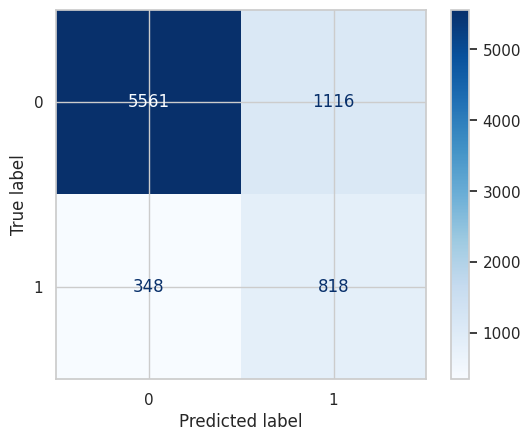

In [90]:
model1.fit(X_train_transformed, y_train)
y_pred = model1.predict(X_val_transformed)
y_predi = model1.predict(test_transformed)
print(classification_report(y_val, y_pred))
print(roc_auc_score(y_val, y_pred))
cm=confusion_matrix(y_val,y_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

              precision    recall  f1-score   support

           0       0.94      0.83      0.88      6677
           1       0.42      0.70      0.53      1166

    accuracy                           0.81      7843
   macro avg       0.68      0.77      0.71      7843
weighted avg       0.86      0.81      0.83      7843

0.7676302203283024
[[5561 1116]
 [ 347  819]]


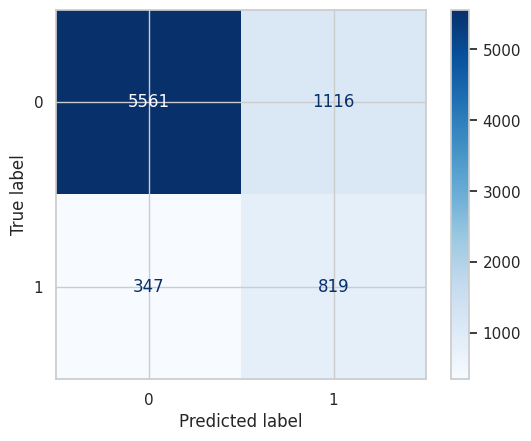

In [91]:
model1.fit(X_train_pca, y_train)
y_pred = model1.predict(X_val_pca)
y_predi = model1.predict(test_pca)
print(classification_report(y_val, y_pred))
print(roc_auc_score(y_val, y_pred))
cm=confusion_matrix(y_val,y_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

              precision    recall  f1-score   support

           0       0.94      0.83      0.88      6677
           1       0.42      0.71      0.53      1166

    accuracy                           0.81      7843
   macro avg       0.68      0.77      0.71      7843
weighted avg       0.86      0.81      0.83      7843

0.7682222272458822
[[5546 1131]
 [ 343  823]]


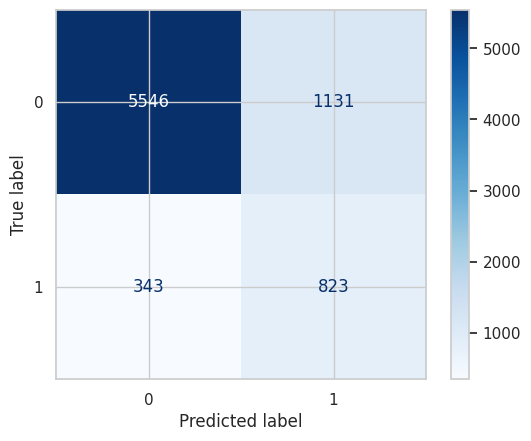

In [92]:
model1.fit(X_train_svd, y_train)
y_pred = model1.predict(X_val_svd)
y_predi = model1.predict(test_svd)
print(classification_report(y_val, y_pred))
print(roc_auc_score(y_val, y_pred))
cm=confusion_matrix(y_val,y_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## **Model Comparison & Model Peformance Analysis**

In [93]:
# Initialize a dictionary to store results
results = {}

# Case 1: Without PCA/SVD
model1.fit(X_train_transformed, y_train)
y_pred = model1.predict(X_val_transformed)
roc_auc = roc_auc_score(y_val, y_pred)
classification_rep = classification_report(y_val, y_pred, output_dict=True)
results['Without Dimensionality Reduction'] = {
    'Accuracy': classification_rep['accuracy'],
    'Precision': classification_rep['1']['precision'],
    'Recall': classification_rep['1']['recall'],
    'F1-Score': classification_rep['1']['f1-score'],
    'ROC AUC': roc_auc,
}

# Case 2: With PCA
model1.fit(X_train_pca, y_train)
y_pred = model1.predict(X_val_pca)
roc_auc = roc_auc_score(y_val, y_pred)
classification_rep = classification_report(y_val, y_pred, output_dict=True)
results['With PCA'] = {
    'Accuracy': classification_rep['accuracy'],
    'Precision': classification_rep['1']['precision'],
    'Recall': classification_rep['1']['recall'],
    'F1-Score': classification_rep['1']['f1-score'],
    'ROC AUC': roc_auc,
}

# Case 3: With SVD
model1.fit(X_train_svd, y_train)
y_pred = model1.predict(X_val_svd)
roc_auc = roc_auc_score(y_val, y_pred)
classification_rep = classification_report(y_val, y_pred, output_dict=True)
results['With SVD'] = {
    'Accuracy': classification_rep['accuracy'],
    'Precision': classification_rep['1']['precision'],
    'Recall': classification_rep['1']['recall'],
    'F1-Score': classification_rep['1']['f1-score'],
    'ROC AUC': roc_auc,
}

# Convert results to a DataFrame for better visualization
comparison_df = pd.DataFrame(results).T
print(comparison_df)


                                  Accuracy  Precision    Recall  F1-Score  \
Without Dimensionality Reduction  0.813337   0.422958  0.701544  0.527742   
With PCA                          0.813464   0.423256  0.702401  0.528217   
With SVD                          0.812062   0.421187  0.705832  0.527564   

                                   ROC AUC  
Without Dimensionality Reduction  0.767201  
With PCA                          0.767630  
With SVD                          0.768222  


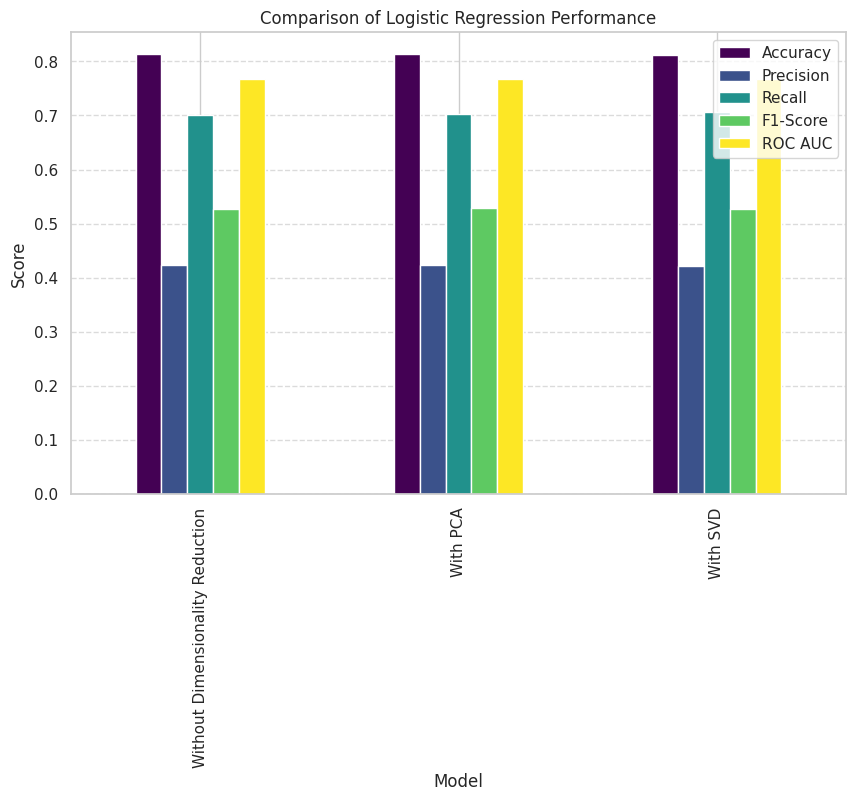

In [94]:
# Bar plot for comparison
comparison_df.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title('Comparison of Logistic Regression Performance')
plt.ylabel('Score')
plt.xlabel('Model')
plt.legend(loc='best')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Using logistic regression, the model achieved a performance score of **0.72188**

# **Decision Tree Classifier**

In [95]:
from sklearn.tree import DecisionTreeClassifier

model2 = DecisionTreeClassifier(random_state = 0)

              precision    recall  f1-score   support

           0       0.91      0.90      0.90      6677
           1       0.45      0.47      0.46      1166

    accuracy                           0.84      7843
   macro avg       0.68      0.69      0.68      7843
weighted avg       0.84      0.84      0.84      7843

0.6859968463975179
[[6017  660]
 [ 617  549]]


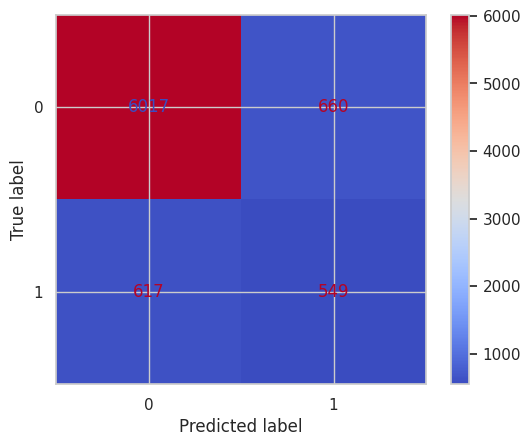

In [96]:
model2.fit(X_train_transformed, y_train)
y_pred = model2.predict(X_val_transformed)
y_predi = model2.predict(test_transformed)
print(classification_report(y_val, y_pred))
print(roc_auc_score(y_val, y_pred))
cm=confusion_matrix(y_val,y_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.coolwarm)
plt.show()

              precision    recall  f1-score   support

           0       0.91      0.90      0.90      6677
           1       0.44      0.46      0.45      1166

    accuracy                           0.83      7843
   macro avg       0.67      0.68      0.67      7843
weighted avg       0.84      0.83      0.83      7843

0.6787133245356489
[[5977  700]
 [ 627  539]]


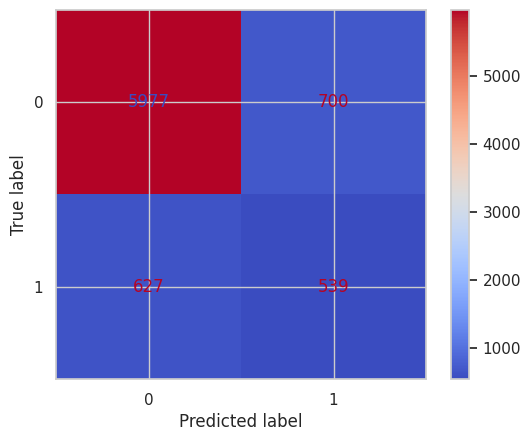

In [97]:
model2.fit(X_train_pca, y_train)
y_pred = model2.predict(X_val_pca)
y_predi = model2.predict(test_pca)
print(classification_report(y_val, y_pred))
print(roc_auc_score(y_val, y_pred))
cm=confusion_matrix(y_val,y_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.coolwarm)
plt.show()

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      6677
           1       0.43      0.43      0.43      1166

    accuracy                           0.83      7843
   macro avg       0.67      0.66      0.66      7843
weighted avg       0.83      0.83      0.83      7843

0.6642020905332584
[[6018  659]
 [ 668  498]]


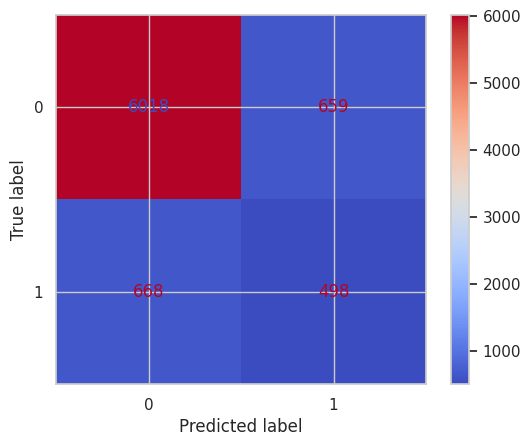

In [98]:
model2.fit(X_train_svd, y_train)
y_pred = model2.predict(X_val_svd)
y_predi = model2.predict(test_svd)
print(classification_report(y_val, y_pred))
print(roc_auc_score(y_val, y_pred))
cm=confusion_matrix(y_val,y_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.coolwarm)
plt.show()

## **Model Comparison & Model Peformance Analysis**

In [99]:
# Initialize a dictionary to store results
results = {}

# Case 1: Without PCA/SVD
model2.fit(X_train_transformed, y_train)
y_pred = model2.predict(X_val_transformed)
roc_auc = roc_auc_score(y_val, y_pred)
classification_rep = classification_report(y_val, y_pred, output_dict=True)
results['Without Dimensionality Reduction'] = {
    'Accuracy': classification_rep['accuracy'],
    'Precision': classification_rep['1']['precision'],
    'Recall': classification_rep['1']['recall'],
    'F1-Score': classification_rep['1']['f1-score'],
    'ROC AUC': roc_auc,
}

# Case 2: With PCA
model2.fit(X_train_pca, y_train)
y_pred = model2.predict(X_val_pca)
roc_auc = roc_auc_score(y_val, y_pred)
classification_rep = classification_report(y_val, y_pred, output_dict=True)
results['With PCA'] = {
    'Accuracy': classification_rep['accuracy'],
    'Precision': classification_rep['1']['precision'],
    'Recall': classification_rep['1']['recall'],
    'F1-Score': classification_rep['1']['f1-score'],
    'ROC AUC': roc_auc,
}

# Case 3: With SVD
model2.fit(X_train_svd, y_train)
y_pred = model2.predict(X_val_svd)
roc_auc = roc_auc_score(y_val, y_pred)
classification_rep = classification_report(y_val, y_pred, output_dict=True)
results['With SVD'] = {
    'Accuracy': classification_rep['accuracy'],
    'Precision': classification_rep['1']['precision'],
    'Recall': classification_rep['1']['recall'],
    'F1-Score': classification_rep['1']['f1-score'],
    'ROC AUC': roc_auc,
}

# Convert results to a DataFrame for better visualization
comparison_df = pd.DataFrame(results).T
print(comparison_df)


                                  Accuracy  Precision    Recall  F1-Score  \
Without Dimensionality Reduction  0.837180   0.454094  0.470840  0.462316   
With PCA                          0.830805   0.435028  0.462264  0.448233   
With SVD                          0.830805   0.430424  0.427101  0.428756   

                                   ROC AUC  
Without Dimensionality Reduction  0.685997  
With PCA                          0.678713  
With SVD                          0.664202  


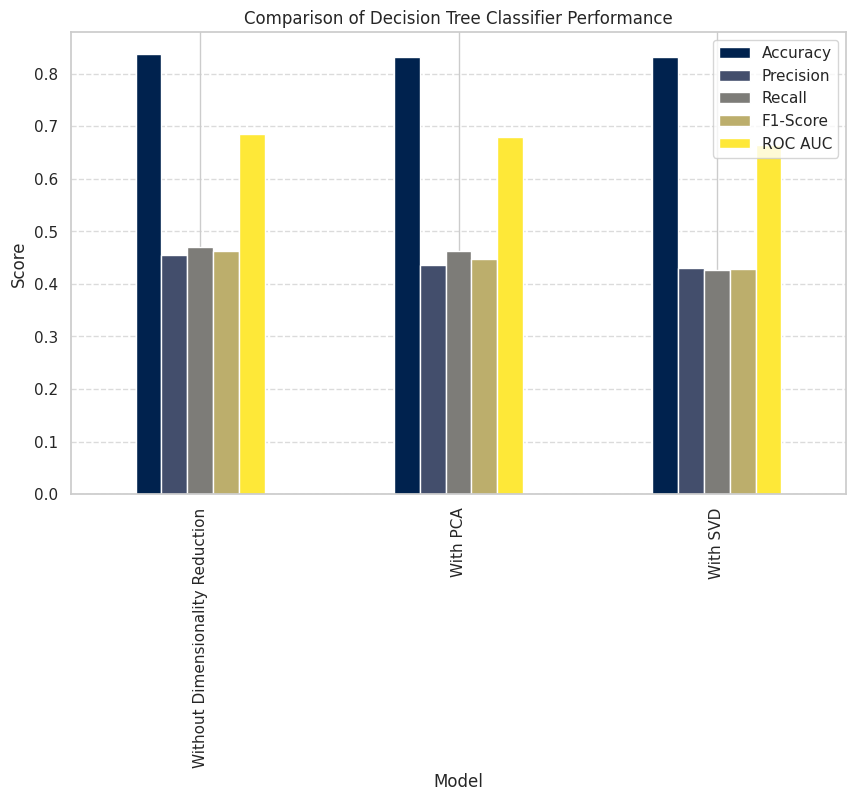

In [100]:
# Bar plot for comparison
comparison_df.plot(kind='bar', figsize=(10, 6), colormap='cividis')
plt.title('Comparison of Decision Tree Classifier Performance')
plt.ylabel('Score')
plt.xlabel('Model')
plt.legend(loc='best')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Using decision tree classifier, the model achieved a performance score of **0.65798**

# **Random Forest Classifier**

In [101]:
from sklearn.ensemble import RandomForestClassifier

model3 = RandomForestClassifier(class_weight = 'balanced', random_state = 0)

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      6677
           1       0.58      0.27      0.37      1166

    accuracy                           0.86      7843
   macro avg       0.73      0.62      0.65      7843
weighted avg       0.84      0.86      0.84      7843

0.6182826995515441
[[6447  230]
 [ 850  316]]


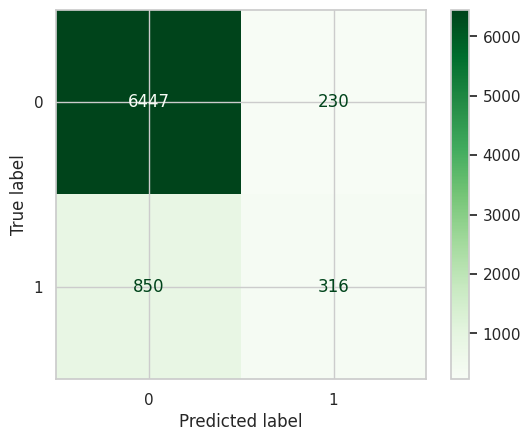

In [102]:
model3.fit(X_train_transformed, y_train)
y_pred = model3.predict(X_val_transformed)
y_predi = model3.predict(test_transformed)
print(classification_report(y_val, y_pred))
print(roc_auc_score(y_val, y_pred))
cm=confusion_matrix(y_val,y_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Greens)
plt.show()

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      6677
           1       0.59      0.27      0.37      1166

    accuracy                           0.86      7843
   macro avg       0.74      0.62      0.65      7843
weighted avg       0.84      0.86      0.84      7843

0.620243104320379
[[6456  221]
 [ 847  319]]


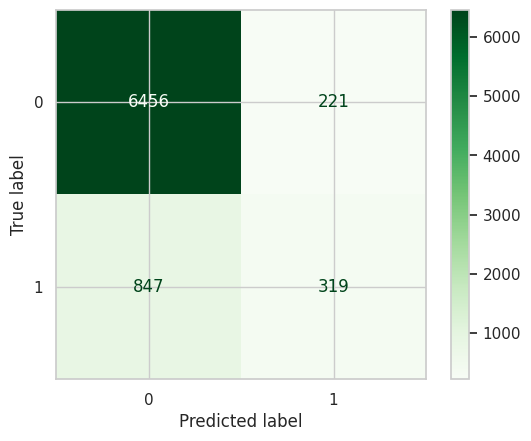

In [103]:
model3.fit(X_train_pca, y_train)
y_pred = model3.predict(X_val_pca)
y_predi = model3.predict(test_pca)
print(classification_report(y_val, y_pred))
print(roc_auc_score(y_val, y_pred))
cm=confusion_matrix(y_val,y_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Greens)
plt.show()

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      6677
           1       0.58      0.27      0.37      1166

    accuracy                           0.86      7843
   macro avg       0.73      0.62      0.65      7843
weighted avg       0.84      0.86      0.84      7843

0.6178743701978914
[[6453  224]
 [ 852  314]]


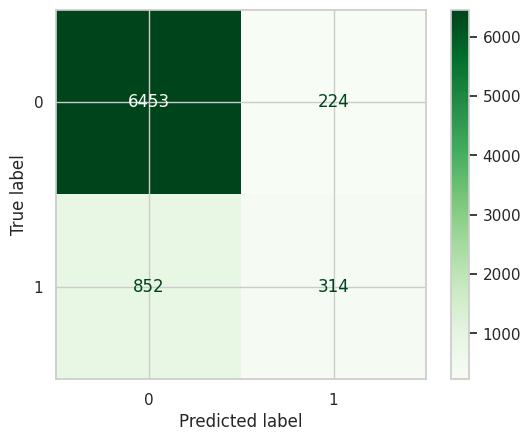

In [104]:
model3.fit(X_train_svd, y_train)
y_pred = model3.predict(X_val_svd)
y_predi = model3.predict(test_svd)
print(classification_report(y_val, y_pred))
print(roc_auc_score(y_val, y_pred))
cm=confusion_matrix(y_val,y_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Greens)
plt.show()

## **Model Comparison & Model Peformance Analysis**

In [105]:
# Initialize a dictionary to store results
results = {}

# Case 1: Without PCA/SVD
model3.fit(X_train_transformed, y_train)
y_pred = model3.predict(X_val_transformed)
roc_auc = roc_auc_score(y_val, y_pred)
classification_rep = classification_report(y_val, y_pred, output_dict=True)
results['Without Dimensionality Reduction'] = {
    'Accuracy': classification_rep['accuracy'],
    'Precision': classification_rep['1']['precision'],
    'Recall': classification_rep['1']['recall'],
    'F1-Score': classification_rep['1']['f1-score'],
    'ROC AUC': roc_auc,
}

# Case 2: With PCA
model3.fit(X_train_pca, y_train)
y_pred = model3.predict(X_val_pca)
roc_auc = roc_auc_score(y_val, y_pred)
classification_rep = classification_report(y_val, y_pred, output_dict=True)
results['With PCA'] = {
    'Accuracy': classification_rep['accuracy'],
    'Precision': classification_rep['1']['precision'],
    'Recall': classification_rep['1']['recall'],
    'F1-Score': classification_rep['1']['f1-score'],
    'ROC AUC': roc_auc,
}

# Case 3: With SVD
model3.fit(X_train_svd, y_train)
y_pred = model3.predict(X_val_svd)
roc_auc = roc_auc_score(y_val, y_pred)
classification_rep = classification_report(y_val, y_pred, output_dict=True)
results['With SVD'] = {
    'Accuracy': classification_rep['accuracy'],
    'Precision': classification_rep['1']['precision'],
    'Recall': classification_rep['1']['recall'],
    'F1-Score': classification_rep['1']['f1-score'],
    'ROC AUC': roc_auc,
}

# Convert results to a DataFrame for better visualization
comparison_df = pd.DataFrame(results).T
print(comparison_df)


                                  Accuracy  Precision    Recall  F1-Score  \
Without Dimensionality Reduction  0.862298   0.578755  0.271012  0.369159   
With PCA                          0.863828   0.590741  0.273585  0.373974   
With SVD                          0.862808   0.583643  0.269297  0.368545   

                                   ROC AUC  
Without Dimensionality Reduction  0.618283  
With PCA                          0.620243  
With SVD                          0.617874  


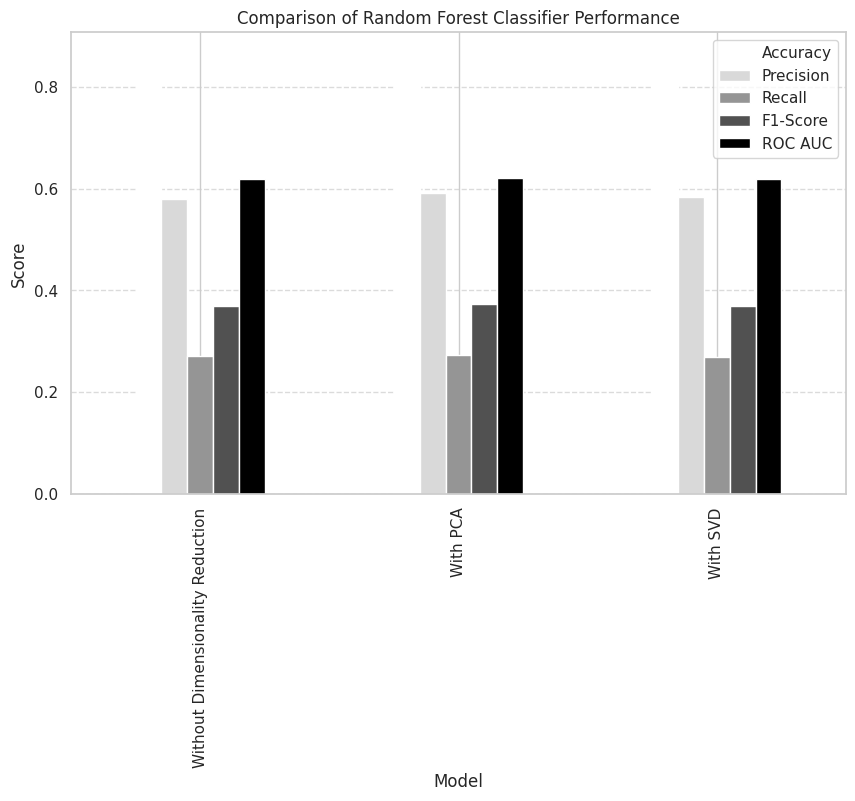

In [106]:
# Bar plot for comparison
comparison_df.plot(kind='bar', figsize=(10, 6), colormap='Greys')
plt.title('Comparison of Random Forest Classifier Performance')
plt.ylabel('Score')
plt.xlabel('Model')
plt.legend(loc='best')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Using random forest classifier, the model achieved a performance score of **0.65816**

# **XGB CLassifier**

In [107]:
from xgboost import XGBClassifier

model4 = XGBClassifier(scale_pos_weight=2)

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      6677
           1       0.54      0.63      0.58      1166

    accuracy                           0.87      7843
   macro avg       0.74      0.77      0.75      7843
weighted avg       0.88      0.87      0.87      7843

0.769718492939717
[[6047  630]
 [ 427  739]]


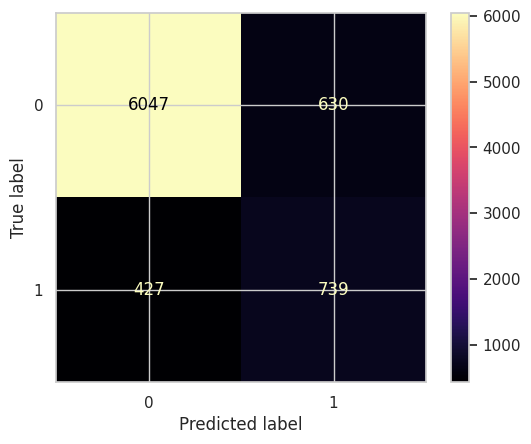

In [108]:
model4.fit(X_train_transformed, y_train)
y_pred = model4.predict(X_val_transformed)
y_predi = model4.predict(test_transformed)
print(classification_report(y_val, y_pred))
print(roc_auc_score(y_val, y_pred))
cm=confusion_matrix(y_val,y_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.magma)
plt.show()

              precision    recall  f1-score   support

           0       0.92      0.91      0.92      6677
           1       0.53      0.56      0.54      1166

    accuracy                           0.86      7843
   macro avg       0.72      0.74      0.73      7843
weighted avg       0.86      0.86      0.86      7843

0.7361351697321981
[[6091  586]
 [ 513  653]]


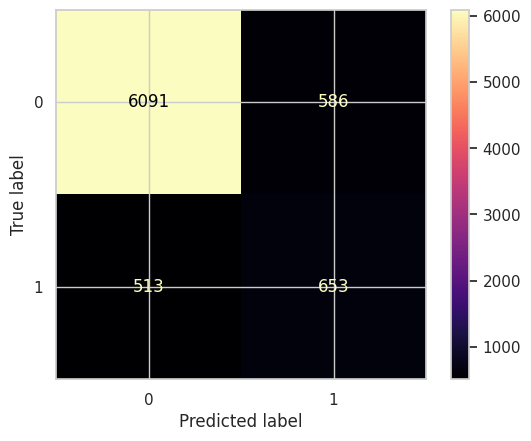

In [109]:
model4.fit(X_train_pca, y_train)
y_pred = model4.predict(X_val_pca)
y_predi = model4.predict(test_pca)
print(classification_report(y_val, y_pred))
print(roc_auc_score(y_val, y_pred))
cm=confusion_matrix(y_val,y_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.magma)
plt.show()

              precision    recall  f1-score   support

           0       0.92      0.91      0.92      6677
           1       0.53      0.57      0.55      1166

    accuracy                           0.86      7843
   macro avg       0.73      0.74      0.73      7843
weighted avg       0.87      0.86      0.86      7843

0.7417097837973782
[[6091  586]
 [ 500  666]]


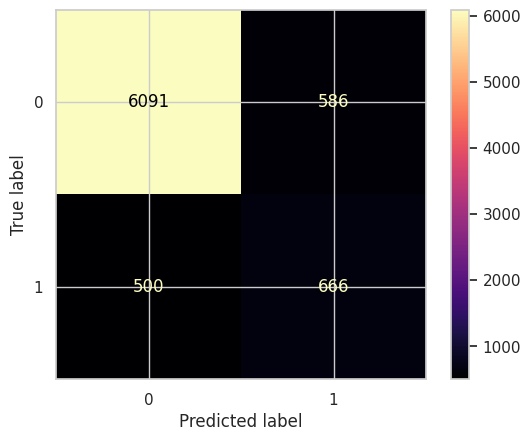

In [110]:
model4.fit(X_train_svd, y_train)
y_pred = model4.predict(X_val_svd)
y_predi = model4.predict(test_svd)
print(classification_report(y_val, y_pred))
print(roc_auc_score(y_val, y_pred))
cm=confusion_matrix(y_val,y_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.magma)
plt.show()

## **Model Comparison & Model Peformance Analysis**

In [111]:
# Initialize a dictionary to store results
results = {}

# Case 1: Without PCA/SVD
model4.fit(X_train_transformed, y_train)
y_pred = model4.predict(X_val_transformed)
roc_auc = roc_auc_score(y_val, y_pred)
classification_rep = classification_report(y_val, y_pred, output_dict=True)
results['Without Dimensionality Reduction'] = {
    'Accuracy': classification_rep['accuracy'],
    'Precision': classification_rep['1']['precision'],
    'Recall': classification_rep['1']['recall'],
    'F1-Score': classification_rep['1']['f1-score'],
    'ROC AUC': roc_auc,
}

# Case 2: With PCA
model4.fit(X_train_pca, y_train)
y_pred = model4.predict(X_val_pca)
roc_auc = roc_auc_score(y_val, y_pred)
classification_rep = classification_report(y_val, y_pred, output_dict=True)
results['With PCA'] = {
    'Accuracy': classification_rep['accuracy'],
    'Precision': classification_rep['1']['precision'],
    'Recall': classification_rep['1']['recall'],
    'F1-Score': classification_rep['1']['f1-score'],
    'ROC AUC': roc_auc,
}

# Case 3: With SVD
model4.fit(X_train_svd, y_train)
y_pred = model4.predict(X_val_svd)
roc_auc = roc_auc_score(y_val, y_pred)
classification_rep = classification_report(y_val, y_pred, output_dict=True)
results['With SVD'] = {
    'Accuracy': classification_rep['accuracy'],
    'Precision': classification_rep['1']['precision'],
    'Recall': classification_rep['1']['recall'],
    'F1-Score': classification_rep['1']['f1-score'],
    'ROC AUC': roc_auc,
}

# Convert results to a DataFrame for better visualization
comparison_df = pd.DataFrame(results).T
print(comparison_df)


                                  Accuracy  Precision    Recall  F1-Score  \
Without Dimensionality Reduction  0.865230   0.539810  0.633791  0.583037   
With PCA                          0.859875   0.527038  0.560034  0.543035   
With SVD                          0.861533   0.531949  0.571184  0.550868   

                                   ROC AUC  
Without Dimensionality Reduction  0.769718  
With PCA                          0.736135  
With SVD                          0.741710  


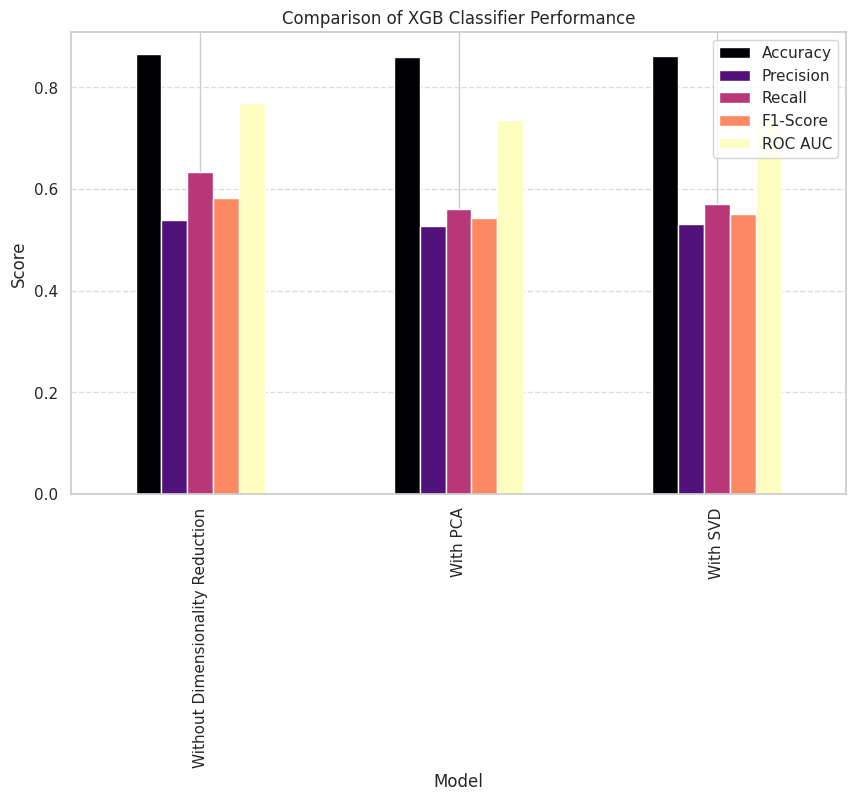

In [112]:
# Bar plot for comparison
comparison_df.plot(kind='bar', figsize=(10, 6), colormap='magma')
plt.title('Comparison of XGB Classifier Performance')
plt.ylabel('Score')
plt.xlabel('Model')
plt.legend(loc='best')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Using XGB Classifier, the model achieved a performance score of **0.74140**

# **KNN**

In [113]:
from sklearn.neighbors import KNeighborsClassifier

model5 = KNeighborsClassifier(n_neighbors=5)

              precision    recall  f1-score   support

           0       0.88      0.95      0.92      6677
           1       0.51      0.28      0.36      1166

    accuracy                           0.85      7843
   macro avg       0.69      0.61      0.64      7843
weighted avg       0.83      0.85      0.83      7843

0.6148443968452671
[[6361  316]
 [ 843  323]]


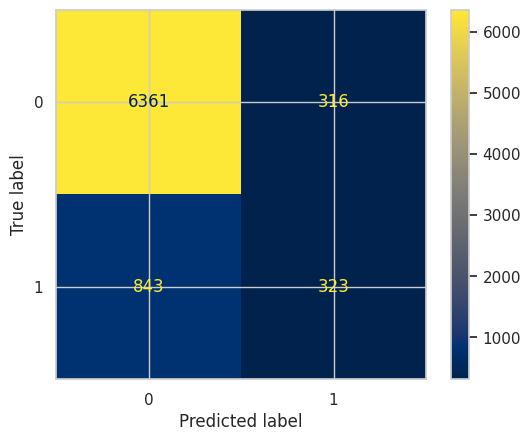

In [114]:
model5.fit(X_train_transformed, y_train)
y_pred = model5.predict(X_val_transformed)
y_predi = model5.predict(test_transformed)
print(classification_report(y_val, y_pred))
print(roc_auc_score(y_val, y_pred))
cm=confusion_matrix(y_val,y_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.cividis)
plt.show()

              precision    recall  f1-score   support

           0       0.88      0.95      0.92      6677
           1       0.51      0.28      0.36      1166

    accuracy                           0.85      7843
   macro avg       0.70      0.62      0.64      7843
weighted avg       0.83      0.85      0.83      7843

0.615518352214445
[[6370  307]
 [ 843  323]]


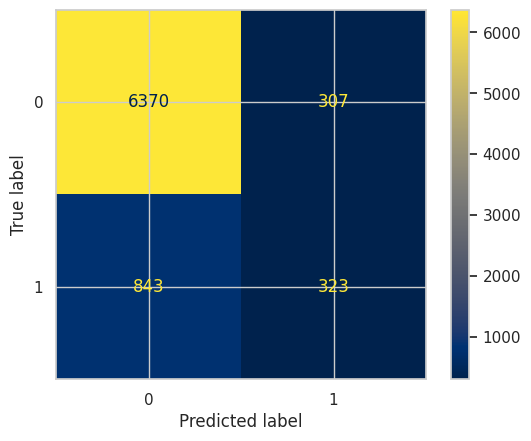

In [115]:
model5.fit(X_train_pca, y_train)
y_pred = model5.predict(X_val_pca)
y_predi = model5.predict(test_pca)
print(classification_report(y_val, y_pred))
print(roc_auc_score(y_val, y_pred))
cm=confusion_matrix(y_val,y_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.cividis)
plt.show()

              precision    recall  f1-score   support

           0       0.88      0.95      0.92      6677
           1       0.51      0.28      0.36      1166

    accuracy                           0.85      7843
   macro avg       0.70      0.62      0.64      7843
weighted avg       0.83      0.85      0.83      7843

0.6155932361443536
[[6371  306]
 [ 843  323]]


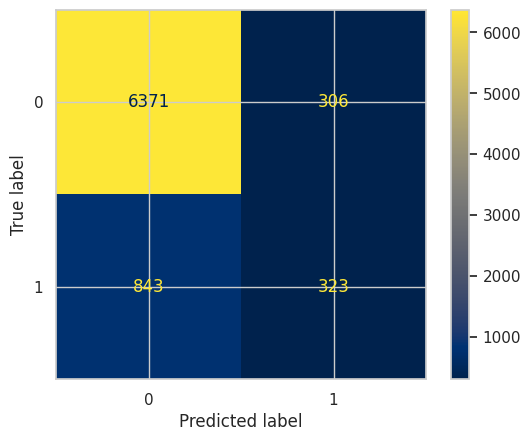

In [116]:
model5.fit(X_train_svd, y_train)
y_pred = model5.predict(X_val_svd)
y_predi = model5.predict(test_svd)
print(classification_report(y_val, y_pred))
print(roc_auc_score(y_val, y_pred))
cm=confusion_matrix(y_val,y_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.cividis)
plt.show()

## **Model Comparison & Model Peformance Analysis**

In [117]:
# Initialize a dictionary to store results
results = {}

# Case 1: Without PCA/SVD
model5.fit(X_train_transformed, y_train)
y_pred = model5.predict(X_val_transformed)
roc_auc = roc_auc_score(y_val, y_pred)
classification_rep = classification_report(y_val, y_pred, output_dict=True)
results['Without Dimensionality Reduction'] = {
    'Accuracy': classification_rep['accuracy'],
    'Precision': classification_rep['1']['precision'],
    'Recall': classification_rep['1']['recall'],
    'F1-Score': classification_rep['1']['f1-score'],
    'ROC AUC': roc_auc,
}

# Case 2: With PCA
model5.fit(X_train_pca, y_train)
y_pred = model5.predict(X_val_pca)
roc_auc = roc_auc_score(y_val, y_pred)
classification_rep = classification_report(y_val, y_pred, output_dict=True)
results['With PCA'] = {
    'Accuracy': classification_rep['accuracy'],
    'Precision': classification_rep['1']['precision'],
    'Recall': classification_rep['1']['recall'],
    'F1-Score': classification_rep['1']['f1-score'],
    'ROC AUC': roc_auc,
}

# Case 3: With SVD
model5.fit(X_train_svd, y_train)
y_pred = model5.predict(X_val_svd)
roc_auc = roc_auc_score(y_val, y_pred)
classification_rep = classification_report(y_val, y_pred, output_dict=True)
results['With SVD'] = {
    'Accuracy': classification_rep['accuracy'],
    'Precision': classification_rep['1']['precision'],
    'Recall': classification_rep['1']['recall'],
    'F1-Score': classification_rep['1']['f1-score'],
    'ROC AUC': roc_auc,
}

# Convert results to a DataFrame for better visualization
comparison_df = pd.DataFrame(results).T
print(comparison_df)


                                  Accuracy  Precision    Recall  F1-Score  \
Without Dimensionality Reduction  0.852225   0.505477  0.277015  0.357895   
With PCA                          0.853372   0.512698  0.277015  0.359688   
With SVD                          0.853500   0.513514  0.277015  0.359889   

                                   ROC AUC  
Without Dimensionality Reduction  0.614844  
With PCA                          0.615518  
With SVD                          0.615593  


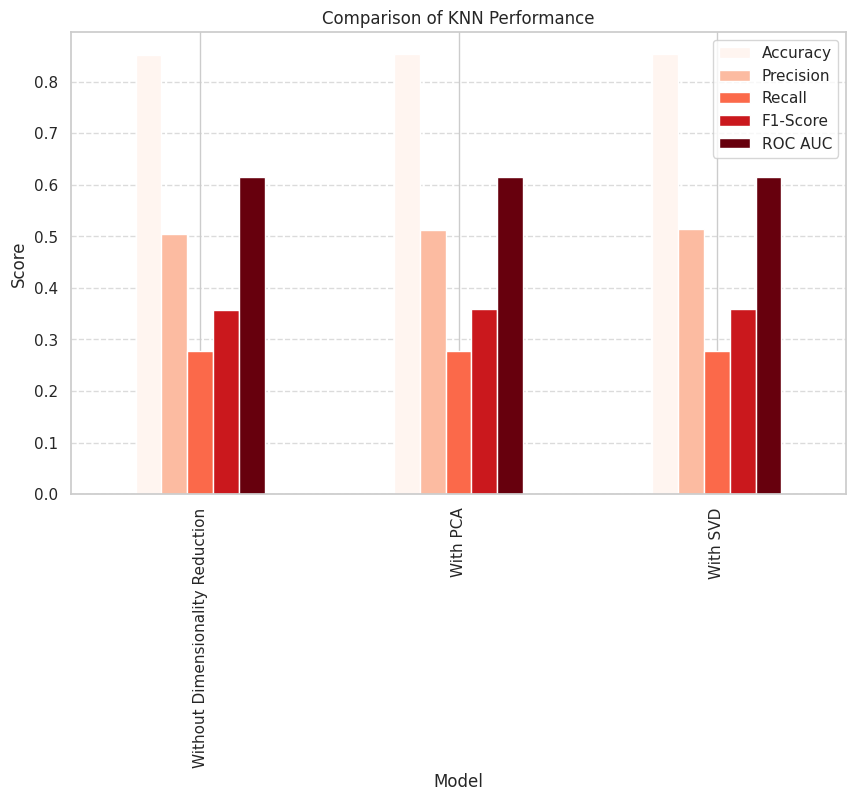

In [118]:
# Bar plot for comparison
comparison_df.plot(kind='bar', figsize=(10, 6), colormap='Reds')
plt.title('Comparison of KNN Performance')
plt.ylabel('Score')
plt.xlabel('Model')
plt.legend(loc='best')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Using KNN , the model achieved a performance score of **0.64816**

# **LGBMClassifier**

In [119]:
from lightgbm import LGBMClassifier

model6 = LGBMClassifier(random_state = 0)

[LightGBM] [Info] Number of positive: 4661, number of negative: 26707
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1247
[LightGBM] [Info] Number of data points in the train set: 31368, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148591 -> initscore=-1.745696
[LightGBM] [Info] Start training from score -1.745696
              precision    recall  f1-score   support

           0       0.91      0.94      0.93      6677
           1       0.58      0.48      0.52      1166

    accuracy                           0.87      7843
   macro avg       0.75      0.71      0.73      7843
weighted avg       0.86      0.87      0.87      7843

0.7088223159762744
[[6276  401]
 [ 609  557]]


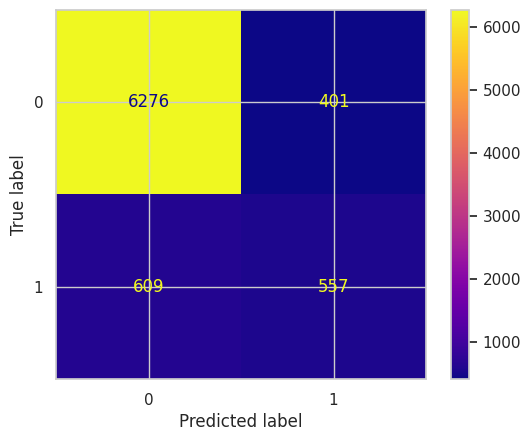

In [120]:
model6.fit(X_train_transformed, y_train)
y_pred = model6.predict(X_val_transformed)
y_predi = model6.predict(test_transformed)
report = classification_report(y_val, y_pred)
print(report)
# acc['lgbm'] = report['macro avg']['f1-score']
print(roc_auc_score(y_val, y_pred))
cm=confusion_matrix(y_val,y_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.plasma)
plt.show()

[LightGBM] [Info] Number of positive: 4661, number of negative: 26707
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 31368, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148591 -> initscore=-1.745696
[LightGBM] [Info] Start training from score -1.745696
              precision    recall  f1-score   support

           0       0.90      0.95      0.92      6677
           1       0.58      0.43      0.49      1166

    accuracy                           0.87      7843
   macro avg       0.74      0.69      0.71      7843
weighted avg       0.86      0.87      0.86      7843

0.686217965926399
[[6312  365]
 [ 668  498]]


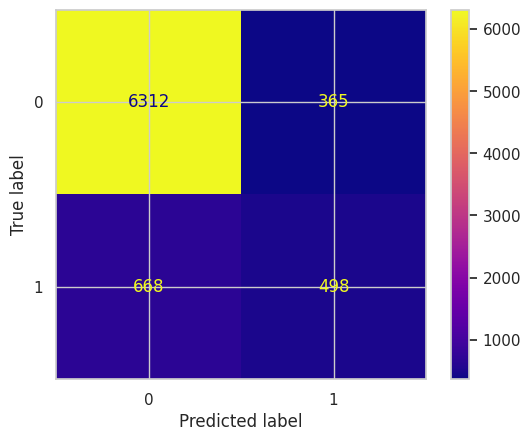

In [121]:
model6.fit(X_train_pca, y_train)
y_pred = model6.predict(X_val_pca)
y_predi = model6.predict(test_pca)
print(classification_report(y_val, y_pred))
print(roc_auc_score(y_val, y_pred))
cm=confusion_matrix(y_val,y_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.plasma)
plt.show()

[LightGBM] [Info] Number of positive: 4661, number of negative: 26707
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 31368, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148591 -> initscore=-1.745696
[LightGBM] [Info] Start training from score -1.745696
              precision    recall  f1-score   support

           0       0.91      0.94      0.93      6677
           1       0.58      0.44      0.50      1166

    accuracy                           0.87      7843
   macro avg       0.75      0.69      0.71      7843
weighted avg       0.86      0.87      0.86      7843

0.6940659430712584
[[6308  369]
 [ 649  517]]


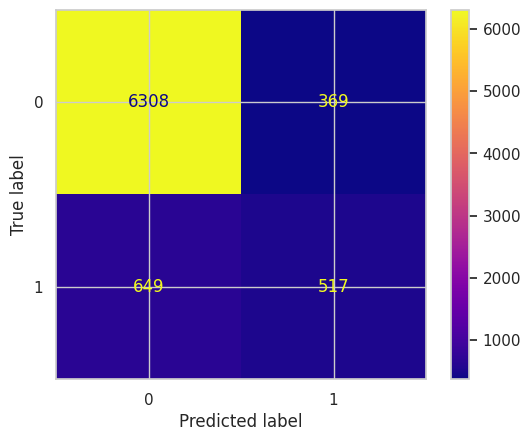

In [122]:
model6.fit(X_train_svd, y_train)
y_pred = model6.predict(X_val_svd)
y_predi = model6.predict(test_svd)
print(classification_report(y_val, y_pred))
print(roc_auc_score(y_val, y_pred))
cm=confusion_matrix(y_val,y_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.plasma)
plt.show()

## **Model Comparison & Model Peformance Analysis**

In [123]:
# Initialize a dictionary to store results
results = {}

# Case 1: Without PCA/SVD
model6.fit(X_train_transformed, y_train)
y_pred = model6.predict(X_val_transformed)
roc_auc = roc_auc_score(y_val, y_pred)
classification_rep = classification_report(y_val, y_pred, output_dict=True)
results['Without Dimensionality Reduction'] = {
    'Accuracy': classification_rep['accuracy'],
    'Precision': classification_rep['1']['precision'],
    'Recall': classification_rep['1']['recall'],
    'F1-Score': classification_rep['1']['f1-score'],
    'ROC AUC': roc_auc,
}

# Case 2: With PCA
model6.fit(X_train_pca, y_train)
y_pred = model6.predict(X_val_pca)
roc_auc = roc_auc_score(y_val, y_pred)
classification_rep = classification_report(y_val, y_pred, output_dict=True)
results['With PCA'] = {
    'Accuracy': classification_rep['accuracy'],
    'Precision': classification_rep['1']['precision'],
    'Recall': classification_rep['1']['recall'],
    'F1-Score': classification_rep['1']['f1-score'],
    'ROC AUC': roc_auc,
}

# Case 3: With SVD
model6.fit(X_train_svd, y_train)
y_pred = model6.predict(X_val_svd)
roc_auc = roc_auc_score(y_val, y_pred)
classification_rep = classification_report(y_val, y_pred, output_dict=True)
results['With SVD'] = {
    'Accuracy': classification_rep['accuracy'],
    'Precision': classification_rep['1']['precision'],
    'Recall': classification_rep['1']['recall'],
    'F1-Score': classification_rep['1']['f1-score'],
    'ROC AUC': roc_auc,
}

# Convert results to a DataFrame for better visualization
comparison_df = pd.DataFrame(results).T
print(comparison_df)


[LightGBM] [Info] Number of positive: 4661, number of negative: 26707
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1247
[LightGBM] [Info] Number of data points in the train set: 31368, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148591 -> initscore=-1.745696
[LightGBM] [Info] Start training from score -1.745696
[LightGBM] [Info] Number of positive: 4661, number of negative: 26707
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 31368, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148591 -> initscore=-1.745696
[Lig

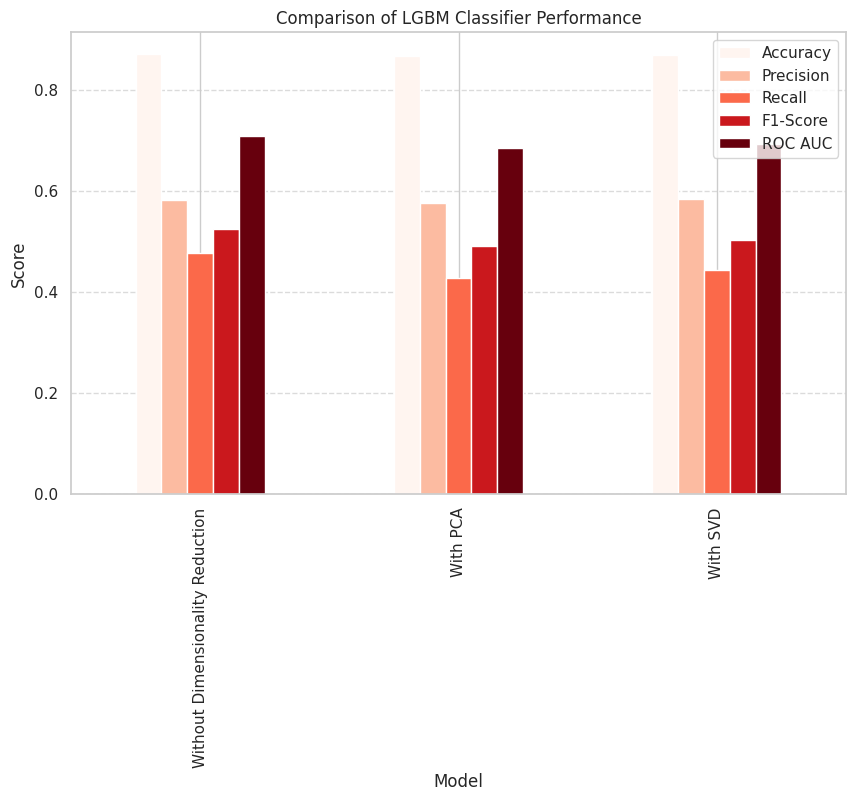

In [124]:
# Bar plot for comparison
comparison_df.plot(kind='bar', figsize=(10, 6), colormap='Reds')
plt.title('Comparison of LGBM Classifier Performance')
plt.ylabel('Score')
plt.xlabel('Model')
plt.legend(loc='best')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Using LGBM Classifier, the model achieved a performance score of **0.71180**

# **Hyper Parameter Tuning**

In [125]:
# Expanded hyperparameter grid
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.5],
    'reg_alpha': [0, 0.1, 1, 10],
    'reg_lambda': [1, 10, 100]
}

# Initialize the XGBClassifier
model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV for better performance
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=50,  # Number of random samples to try
    scoring='roc_auc',  # Optimizing for ROC-AUC score
    cv=cv,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit RandomizedSearchCV
random_search.fit(X_train_transformed, y_train)

# Extract the best parameters
best_parameters = random_search.best_params_
print("Best Parameters:", best_parameters)

# Train the best model with early stopping
best_model = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    **best_parameters
)
best_model.fit(
    X_train_transformed,
    y_train,
    early_stopping_rounds=10,  # Stop training if validation performance doesn't improve
    eval_set=[(X_val_transformed, y_val)],
    verbose=False
)

# Make predictions
y_pred = best_model.predict(X_val_transformed)
y_pred_prob = best_model.predict_proba(X_val_transformed)[:, 1]  # For ROC-AUC

# Generate evaluation metrics
print("Classification Report:\n", classification_report(y_val, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_val, y_pred_prob))


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=200, reg_alpha=10, reg_lambda=1, subsample=0.6; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=200, reg_alpha=10, reg_lambda=1, subsample=0.6; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=200, reg_alpha=10, reg_lambda=1, subsample=0.6; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=200, reg_alpha=10, reg_lambda=1, subsample=0.6; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=5, n_estimators=200, reg_alpha=10, reg_lambda=1, subsample=0.6; total time=   1.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=300, reg_alpha=10, reg_lambda=10, subsample=1.0; total time=   1.4s
[CV] END 

### **Insights**
After Hyper Parameter Tuning the model achieved a performance score of **0.74462**.

In [126]:
prediction = pd.DataFrame({'target': y_predi}, index=range(len(y_predi)))
prediction.index.name = 'id'

prediction['target'] = prediction['target'].map({0: 'no', 1: 'yes'})

prediction.to_csv('submission.csv')
